# Índice

1. Preparar el Entorno
2. Descarga de los Datos
  - Descarga del Dataset
  - Carga de los Datos
  - Descarga y Procesameinto de Imágenes
  - Guardar los Datos
  - Comprobación y Recarga de los Datos
3. Análisis Exploratorio Inicial de los Datos (EDA)
4. Dividir los Datos en Train, Validación y Test y Guardar
5. Limpiar Códigos Postales
6. Análisis de la correlación
7. Preprocesamiento
  - Generación de nuevas variables
  - Limpieza de características
  - Filtrado de datos
  - Codificación de características de texto o categóricas
  - Imputar datos faltantes
  - Normalización y Estandarización

El objetivo de esta fase es **cargar, limpiar y preparar los datos para el modelado**, lo que implica manipulación de datos y visualización para entender mejor los datos que estamos trabajando.

# 1. Preparar el Entorno

In [1]:
# Importar las bibliotecas necesarias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import imageio.v3 as io
from tqdm import tqdm
from typing import Optional, Union
from pandas.plotting import scatter_matrix
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Establecer opciones de visualización para mostrar todas las filas y columnas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Mar  3 14:54:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# 2. Descarga de los datos

## Descarga del Dataset

Utilizamos el comando `!wget` para descargar el dataset de listados de Airbnb desde el portal [OpenDataSoft](https://public.opendatasoft.com/explore/dataset/airbnb-listings/table/?disjunctive.host_verifications&disjunctive.amenities&disjunctive.features).

Este dataset incluye información variada sobre alojamientos.

In [4]:
!wget -O "airbnb-listings.csv" "https://public.opendatasoft.com/explore/dataset/airbnb-listings/download/?format=csv&disjunctive.host_verifications=true&disjunctive.amenities=true&disjunctive.features=true&refine.country=Spain&q=Madrid&timezone=Europe/London&use_labels_for_header=true&csv_separator=%3B"

--2024-03-03 14:55:10--  https://public.opendatasoft.com/explore/dataset/airbnb-listings/download/?format=csv&disjunctive.host_verifications=true&disjunctive.amenities=true&disjunctive.features=true&refine.country=Spain&q=Madrid&timezone=Europe/London&use_labels_for_header=true&csv_separator=%3B
Resolving public.opendatasoft.com (public.opendatasoft.com)... 34.249.199.226, 34.248.20.69
Connecting to public.opendatasoft.com (public.opendatasoft.com)|34.249.199.226|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/csv]
Saving to: ‘airbnb-listings.csv’

airbnb-listings.csv     [         <=>        ]  52.85M  12.1MB/s    in 5.2s    

2024-03-03 14:55:16 (10.2 MB/s) - ‘airbnb-listings.csv’ saved [55414009]



## Cargar los Datos

Cargamos el dataset usando `pandas.read_csv`, especificando `;` como separador debido al formato del archivo CSV. Después, realizamos una inspección inicial para familiarizarnos con las columnas.

In [5]:
data = pd.read_csv("airbnb-listings.csv", sep = ';')

In [6]:
# Conocemos las variables
data.columns

Index(['ID', 'Listing Url', 'Scrape ID', 'Last Scraped', 'Name', 'Summary',
       'Space', 'Description', 'Experiences Offered', 'Neighborhood Overview',
       'Notes', 'Transit', 'Access', 'Interaction', 'House Rules',
       'Thumbnail Url', 'Medium Url', 'Picture Url', 'XL Picture Url',
       'Host ID', 'Host URL', 'Host Name', 'Host Since', 'Host Location',
       'Host About', 'Host Response Time', 'Host Response Rate',
       'Host Acceptance Rate', 'Host Thumbnail Url', 'Host Picture Url',
       'Host Neighbourhood', 'Host Listings Count',
       'Host Total Listings Count', 'Host Verifications', 'Street',
       'Neighbourhood', 'Neighbourhood Cleansed',
       'Neighbourhood Group Cleansed', 'City', 'State', 'Zipcode', 'Market',
       'Smart Location', 'Country Code', 'Country', 'Latitude', 'Longitude',
       'Property Type', 'Room Type', 'Accommodates', 'Bathrooms', 'Bedrooms',
       'Beds', 'Bed Type', 'Amenities', 'Square Feet', 'Price', 'Weekly Price',
       'Month

Comprobamos y manejamos los valores faltantes en las columnas `Price` (variable objetivo clave) y `Thumbnail Url`, para asegurarnos de que solo trabajamos con registros completos para nuestras variables de interés.

In [7]:
missing_values_price = data['Price'].isnull().sum()
print(data.shape, missing_values_price)

(14001, 89) 11


In [8]:
missing_values_images = data['Thumbnail Url'].isnull().sum()
print(data.shape, missing_values_images)

(14001, 89) 2712


Eliminamos los registros donde `Price` o `Thumbnail Url` son NaN dada la importancia de estas variables para nuestro análisis:

In [9]:
data = data.dropna(subset=['Price', 'Thumbnail Url'])

In [10]:
data.shape

(11285, 89)

## Descarga y Procesamiento de imágenes

**Aclaración:** Inicialmente, intentamos descargar todas las imágenes para preprocesamiento. Sin embargo, debido a restricciones de memoria en Colab, ajustamos nuestra estrategia para descargar imágenes solo después de dividir los datos, optimizando el uso de recursos. *(Explicación detallada al final del archivo)*

**Aprendizaje:** Este desafío subraya la importancia de gestionar eficientemente los recursos computacionales, especialmente al trabajar con grandes volúmenes de datos y en entornos con limitaciones de memoria.

**Lo que se hizo inicialmente:** La función `download_images` descarga imágenes de las URLs proporcionadas, las redimensiona a un tamaño uniforme (224x224) y las convierte a un formato numérico adecuado para el entrenamiento de modelos. Preparamos los datos visuales para luego entrenar un modelo basado en imágenes.

Dejamos comentada la función porque finalmente no se decidió hacer la descarga en esta etapa del proceso.

In [ ]:
"""
from typing import Optional, List, Tuple
from skimage import io

def download_images(paths: List[str],
                    ids: np.ndarray,
                    canvas: Tuple[int, int] = (224, 224),
                    nb_channels: int = 3,
                    max_imgs: Optional[int] = None
                   ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Descarga una lista de imágenes desde direcciones URL,
    convirtiéndolas a un tamaño de lienzo específico y asociándolas a sus IDs.

    Argumentos:
      - paths: Rutas o direcciones URL desde las cuales cargar imágenes.
      - ids: Arreglo de IDs correspondiente a cada ruta.
      - canvas: Ancho y alto de la imagen deseada.
      - nb_channels: Canales en las imágenes (1 para blanco y negro, 3 para RGB).
      - max_imgs: Umbral superior en la cantidad de imágenes a descargar.

    Retorno:
      Una tupla de:
        - Arreglo de imágenes descargadas.
        - Arreglo de IDs correspondientes a las imágenes exitosamente descargadas.
        - Índices dentro de los paths que fueron exitosos.
    """
    n_images = min(len(paths), len(ids)) if not max_imgs else min(max_imgs, len(paths), len(ids))
    images = np.zeros((n_images, canvas[0], canvas[1], nb_channels), dtype=np.uint8)
    successful_ids = []
    downloaded_idxs = []

    for i_img, (url, img_id) in enumerate(tqdm(zip(paths, ids), total=n_images)):
        if i_img >= n_images:
            break
        try:
            img = io.imread(url)
            if img.ndim == 2:  # Convertir blanco y negro a RGB si es necesario
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            img = cv2.resize(img, (canvas[0], canvas[1]))
            images[i_img] = img
            successful_ids.append(img_id)
            downloaded_idxs.append(i_img)
        except (IOError, ValueError) as e:  # Unavailable url / conversion error
            pass

    # Asegurarse de que sólo se devuelven las imágenes e IDs exitosamente descargados
    return images[:len(downloaded_idxs)], np.array(successful_ids), downloaded_idxs

"""

**Normalización y conversión en el rango [0, 1]:**



In [ ]:
"""
images, ids, idxs = download_images(data['Thumbnail Url'].to_numpy(), data['ID'].to_numpy())
images = images.astype("float32") / 255.
images.shape
"""

**Montamos Google Drive:**

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
!ls "/content/drive/My Drive/deep_learning"

1_preprocesado_datos.ipynb  filtered_data.csv	     imagenes_val.npy	    train_test_split
DeepLearning-Airbnb.ipynb   imagenes_procesadas.npy  images_final_3000.npy
downloadData.ipynb	    imagenes_test.npy	     images_with_ids.h5
filtered_data_3000.csv	    imagenes_train.npy	     primeros-archivos


**Filtrado acorde a los demás datos:**

In [ ]:
#filtered_data = data.iloc[idxs]

In [ ]:
#filtered_data.shape

## Guardar los Datos

In [ ]:
filtered_data.to_csv('/content/drive/My Drive/deep_learning/filtered_data.csv', sep=';', index=False)

Después de la limpieza inicial, guardamos el dataset limpio en un nuevo archivo CSV para facilitar su acceso en pasos futuros.

Posteriormente, recargamos estos datos limpios para continuar con el análisis exploratorio.

Este enfoque nos permite tener un punto de partida claro y consistente para el análisis y modelado subsiguientes, asegurando la reproducibilidad del proceso.

## Comprobación y Recarga de los Datos

In [13]:
%cd /content/drive/MyDrive/deep_learning
!cp filtered_data.csv /content/drive/MyDrive/deep_learning/filtered_data.csv

# !ls -lah images* filtered*  # Comprobación

/content/drive/MyDrive/deep_learning
cp: 'filtered_data.csv' and '/content/drive/MyDrive/deep_learning/filtered_data.csv' are the same file


In [14]:
# Comprobamos a abrirlos de nuevo
data = pd.read_csv("/content/drive/MyDrive/deep_learning/filtered_data.csv", sep=';')
print(data.shape)

(8810, 89)


<ipython-input-14-abcebf7749b1>:2: DtypeWarning: Columns (40) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("/content/drive/MyDrive/deep_learning/filtered_data.csv", sep=';')


Pandas emite una advertencia sobre tipos de datos mixtos en una de las columnas, sugiriendo que se especifique explícitamente el tipo de dato de la columna o se ajuste un parámetro para manejar mejor la inferencia de tipos de datos. Tendremos esto en cuenta.

In [15]:
data['Price'].describe()

count    8806.000000
mean       66.466273
std        64.444615
min         9.000000
25%        30.000000
50%        50.000000
75%        80.000000
max       850.000000
Name: Price, dtype: float64

La amplia gama de precios y su distribución sugieren que nuestro modelo deberá manejar efectivamente una *gran variabilidad* en los valores objetivo. Además, la presencia de **precios extremadamente altos** podría indicar la existencia de **valores atípicos**, lo cual deberemos abordar durante la fase de preprocesamiento para evitar sesgos en las predicciones de nuestro modelo.

# 3. Análisis Exploratorio de los Datos (EDA)

Realizamos un análisis exploratorio detallado, utilizando visualizaciones como histogramas y gráficos de dispersión para entender mejor la distribución de los precios, la ubicación de los alojamientos, y otras características relevantes.

El análisis más detallado se encuentra en el [repositorio del proyecto anterior de Machine Learning](https://github.com/rociobenitez/AirbnbPricingModel).

## Análisis Inicial

In [16]:
data.describe()

,ID,Scrape ID,Picture Url,Host ID,Host Response Rate,Host Acceptance Rate,Host Listings Count,Host Total Listings Count,Latitude,Longitude,Accommodates,Bathrooms,Bedrooms,Beds,Square Feet,Price,Weekly Price,Monthly Price,Security Deposit,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Has Availability,Availability 30,Availability 60,Availability 90,Availability 365,Number of Reviews,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,Jurisdiction Names,Calculated host listings count,Reviews per Month
count,8.810000e+03,8.810000e+03,0.0,8.810000e+03,7637.000000,0.0,8807.000000,8807.000000,8810.000000,8810.000000,8810.000000,8773.000000,8789.000000,8774.000000,309.000000,8806.000000,2064.000000,2001.000000,3683.00000,5070.000000,8810.000000,8810.000000,8810.000000,8810.000000,0.0,8810.000000,8810.000000,8810.000000,8810.000000,8810.000000,6858.000000,6848.000000,6850.000000,6841.000000,6851.00000,6841.000000,6840.000000,0.0,8810.000000,6935.000000
mean,1.082394e+07,2.017041e+13,NaN,3.928425e+07,95.845227,NaN,11.223004,11.223004,40.430294,-3.460660,3.086720,1.257723,1.293663,1.938568,354.566343,66.466273,354.085271,1308.066967,179.23622,28.688363,1.539387,6.935982,2.464813,1009.791033,NaN,8.429852,22.071169,38.744381,196.246652,24.235074,91.990085,9.454001,9.357372,9.643327,9.66545,9.531355,9.252778,NaN,8.028150,2.043815
std,5.481048e+06,1.156222e+07,NaN,3.533360e+07,13.258605,NaN,32.851693,32.851693,0.179147,1.184042,1.954057,0.617082,0.821525,1.488582,496.521164,64.444615,185.586198,1027.176905,103.65705,21.852027,1.086916,9.821022,2.290107,10870.899121,NaN,9.038076,19.369276,29.223691,128.249849,39.581573,8.561620,0.873603,0.964636,0.763161,0.72527,0.773985,0.925500,NaN,19.903402,1.891696
min,2.151200e+04,2.017032e+13,NaN,1.985400e+04,0.000000,NaN,0.000000,0.000000,39.317472,-3.863907,1.000000,0.000000,0.000000,1.000000,0.000000,9.000000,70.000000,270.000000,70.00000,4.000000,1.000000,0.000000,1.000000,1.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,2.000000,2.000000,2.00000,2.000000,2.000000,NaN,1.000000,0.020000
25%,6.370531e+06,2.017041e+13,NaN,8.317577e+06,100.000000,NaN,1.000000,1.000000,40.409796,-3.708099,2.000000,1.000000,1.000000,1.000000,0.000000,30.000000,200.000000,650.000000,100.00000,15.000000,1.000000,0.000000,1.000000,365.000000,NaN,0.000000,4.000000,11.000000,73.000000,1.000000,89.000000,9.000000,9.000000,9.000000,9.00000,9.000000,9.000000,NaN,1.000000,0.570000
50%,1.217184e+07,2.017041e+13,NaN,2.888100e+07,100.000000,NaN,2.000000,2.000000,40.419493,-3.701046,2.000000,1.000000,1.000000,1.000000,85.000000,50.000000,329.000000,1150.000000,150.00000,25.000000,1.000000,0.000000,2.000000,1125.000000,NaN,6.000000,18.000000,36.000000,224.000000,8.000000,94.000000,10.000000,10.000000,10.000000,10.00000,10.000000,9.000000,NaN,2.000000,1.460000
75%,1.566696e+07,2.017041e+13,NaN,6.105058e+07,100.000000,NaN,5.000000,5.000000,40.430195,-3.688528,4.000000,1.000000,1.000000,2.000000,646.000000,80.000000,460.000000,1600.000000,200.00000,35.000000,2.000000,12.000000,3.000000,1125.000000,NaN,13.000000,37.000000,63.000000,314.000000,30.000000,98.000000,10.000000,10.000000,10.000000,10.00000,10.000000,10.000000,NaN,4.000000,3.010000
max,1.810984e+07,2.017041e+13,NaN,1.247388e+08,100.000000,NaN,207.000000,207.000000,41.434567,3.467897,16.000000,8.000000,10.000000,16.000000,3014.000000,850.000000,980.000000,25000.000000,950.00000,260.000000,16.000000,276.000000,27.000000,1000000.000000,NaN,30.000000,60.000000,90.000000,365.000000,446.000000,100.000000,10.000000,10.000000,10.000000,10.00000,10.000000,10.000000,NaN,145.000000,13.600000


In [17]:
data.head()

,ID,Listing Url,Scrape ID,Last Scraped,Name,Summary,Space,Description,Experiences Offered,Neighborhood Overview,Notes,Transit,Access,Interaction,House Rules,Thumbnail Url,Medium Url,Picture Url,XL Picture Url,Host ID,Host URL,Host Name,Host Since,Host Location,Host About,Host Response Time,Host Response Rate,Host Acceptance Rate,Host Thumbnail Url,Host Picture Url,Host Neighbourhood,Host Listings Count,Host Total Listings Count,Host Verifications,Street,Neighbourhood,Neighbourhood Cleansed,Neighbourhood Group Cleansed,City,State,Zipcode,Market,Smart Location,Country Code,Country,Latitude,Longitude,Property Type,Room Type,Accommodates,Bathrooms,Bedrooms,Beds,Bed Type,Amenities,Square Feet,Price,Weekly Price,Monthly Price,Security Deposit,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Calendar Updated,Has Availability,Availability 30,Availability 60,Availability 90,Availability 365,Calendar last Scraped,Number of Reviews,First Review,Last Review,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,License,Jurisdiction Names,Cancellation Policy,Calculated host listings count,Reviews per Month,Geolocation,Features
0,17823671,https://www.airbnb.com/rooms/17823671,20170407214119,2017-04-08,Room in beautiful flat in Madrid centre!! SC8_1_2,Great room with large bed and two windows,Amazing 12 bedroom flat with 3 complete bathro...,Great room with large bed and two windows Amaz...,none,"The "" Barrio de las Letras "" is one of the mos...","*Bedding and sheets are not included, please c...","Metro Sevilla – line 2 Metro Sol – lines 1, 2 ...","It has all the amenities you need, such as a c...",Hi :) I don´t live in the flat but you can co...,NaN,https://a0.muscache.com/im/pictures/5b9ec2c3-f...,https://a0.muscache.com/im/pictures/5b9ec2c3-f...,NaN,https://a0.muscache.com/im/pictures/5b9ec2c3-f...,65068845,https://www.airbnb.com/users/show/65068845,Adriana,2016-03-30,"Madrid, Community of Madrid, Spain",NaN,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/a57e9580-9...,https://a0.muscache.com/im/pictures/a57e9580-9...,Embajadores,20.0,20.0,"email,phone,facebook,jumio,government_id,work_...","Madrid, Comunidad de Madrid 28014, Spain",NaN,Cortes,Centro,Madrid,Comunidad de Madrid,28014,Madrid,"Madrid, Spain",ES,Spain,40.414871,-3.696578,Apartment,Private room,1,1.0,1.0,1.0,Real Bed,"TV,Wireless Internet,Kitchen,Elevator in build...",NaN,35.0,NaN,NaN,200.0,30.0,1,0,7,1125,3 weeks ago,NaN,0,5,35,61,2017-04-08,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,strict,20,NaN,"40.41487093316894,-3.6965780975998435","Host Has Profile Pic,Host Identity Verified,Re..."
1,801113,https://www.airbnb.com/rooms/801113,20170407214119,2017-04-08,DOUBLE ROOM WITH PRIVATE BATHROOM IN LA LATINA,Bright and spacious double room and bathroom f...,Spacious double room with private bathroom and...,Bright and spacious double room and bathroom f...,none,".Safety neighborhood with all the amenities, g...",Extra fees: .If your arrival time to the apart...,There are two ways coming from the airport dep...,"-Coffee and tea available. -Towels, bed linens...","I am local, born in Madrid and I will provide ...",Just a few common sense rules apply; be respec...,https://a0.muscache.com/im/pictures/11494964/3...,https://a0.muscache.com/im/pictures/11494964/3...,NaN,https://a0.muscache.com/im/pictures/11494964/3...,4216926,https://www.airbnb.com/users/show/4216926,Berta,2012-11-22,"Madrid, Community of Madrid, Spain",¡Hola! Me gusta viajar y conocer lugares difer...,within a few hours,100.0,NaN,https://a0.muscache.com/im/users/4216926/profi...,https://a0.muscache.com/im/users/4216926/profi...,La Latina,1.0,1.0,"email,phone,reviews","La Latina, Madrid, Community of Madrid 28005, ...",La Latina,Palacio,Centro,Madrid,Community of Madrid,28005,Madrid,"Madrid, Spain",ES,Spain,40.408601,-3.714596,Apartment,Private room,2,2.0,1.0,1.0,Real Bed,"TV,Cable TV,I

### Observar Tipos de Datos

In [18]:
# data.dtypes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8810 entries, 0 to 8809
Data columns (total 89 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID                              8810 non-null   int64  
 1   Listing Url                     8810 non-null   object 
 2   Scrape ID                       8810 non-null   int64  
 3   Last Scraped                    8810 non-null   object 
 4   Name                            8810 non-null   object 
 5   Summary                         8500 non-null   object 
 6   Space                           6420 non-null   object 
 7   Description                     8804 non-null   object 
 8   Experiences Offered             8810 non-null   object 
 9   Neighborhood Overview           5415 non-null   object 
 10  Notes                           3311 non-null   object 
 11  Transit                         5427 non-null   object 
 12  Access                          49

> Comprobamos que todas las filas tienen una imagen asociada (`Thumbnail Url`)

### Analisis de la ubicación de los alojamientos

In [19]:
print(f"Valores únicos en 'Zipcode': {data['Zipcode'].unique()}")
print(f"Valores únicos en 'City': {data['City'].unique()}")
print(f"Valores únicos en 'State': {data['State'].unique()}")
print(f"Valores únicos en 'Country': {data['Country'].unique()}")
print(f"Valores únicos en 'Country Code': {data['Country Code'].unique()}")

Valores únicos en 'Zipcode': ['28014' '28005' '28027' '28045' '28030' '28034' '28013' '28004' '28015'
 '28012' '28025' '28019' '28010' '28028' nan '28046' '28037' '28042'
 '28003' '28008' '28018' '28039' '28007' '08010' '28001' '28026' '28011'
 '07181' '28022' '07170' '28038' '28047' '28029' '280013' '28041' '28009'
 '28035' '28006' '28020' '28017' '28021' '07013' '28043' '28055' '28016'
 '08009' '28040' '28033' '28031' '28053' '08038' '28002' '08007' '08004'
 '28051' '28032' '08037' '08008' '28023' '07609' '07001' '20126' '07002'
 '2804' '28050' '08025' '08012' '28290' '07610' '07004' '28024' '28036'
 '07010' '07210' '08002' '08022' '2815' '08021' '08018' '07470' '28054'
 '08003' '07510' '07400' '07183' '08014' '08024' '07660' '07011' '07590'
 '08029' '08019' '07350' '07015' '08015' '07200' '28044' '08026' '08031'
 '07240' '07518' '28049' '07639' '07669' '07012' '7011' '07320' '08028'
 '07300' '28224' '08036' '08011' '07680' '07005' '08001' '07003' '08013'
 '07108' '08005' '07100' '07

In [20]:
print(data['City'].value_counts())
#print(Counter(data['City']))

Madrid                                 8373
Barcelona                               198
马德里                                      50
Palma                                    36
Alcúdia                                  12
Madrid, Comunidad de Madrid, ES          10
Palma de Mallorca                         7
madrid                                    5
Pollença                                  5
Inca                                      4
Sóller                                    4
Can Pastilla                              4
Illetes                                   4
Llucmajor                                 4
Valldemossa                               4
Torrenova                                 3
Pozuelo de Alarcón                        3
Urbanització Montferrutx                  2
Búger                                     2
Betlem                                    2
Son Servera                               2
Santa Maria del Camí                      2
Cala Ferrera                    

### Filtrado Inicial General: Alojamientos en Madrid

Decidimos **enfocar el análisis solo en los registros de Madrid** debido a la predominancia de estos en el conjunto de datos, representando 1787 de los 1876 totales. Excluir los demás registros nos permite mantener la coherencia y relevancia geográfica, asegurando que el análisis refleje más fielmente las condiciones del mercado inmobiliario de Madrid sin la influencia desproporcionada de una muestra mínima no representativa de otras ciudades.

In [21]:
# Filtrar el DataFrame para incluir solo registros de Madrid
data_madrid = data[data['City'] == 'Madrid']

# Utilizaremos este DataFrame filtrado para el análisis y modelado

In [22]:
print(data_madrid["Zipcode"].value_counts().keys().tolist())
print(data_madrid["Zipcode"].value_counts().tolist())

['28012', '28004', '28005', '28013', '28015', '28014', '28045', '28008', '28010', '28028', '28001', '28011', '28019', '28003', '28009', '28007', '28020', '28002', '28039', '28006', 28012.0, '28027', '28025', 28004.0, '28042', '28029', '28017', '28043', '28026', '28033', '28053', '28016', '28030', 28013.0, '28038', '28021', '28035', '28047', '28050', 28005.0, '28041', '28036', '28037', 28015.0, 28014.0, '28024', '28018', '28034', '28032', 28045.0, '28022', '28046', '28031', '28023', 28008.0, '28040', 28028.0, 28010.0, 28020.0, 28006.0, 28009.0, '28054', 28019.0, 28011.0, 28039.0, '28044', '28051', '28055', 28007.0, 28033.0, 28027.0, 28002.0, 28017.0, 28025.0, 28043.0, 28053.0, 28037.0, 28024.0, 28030.0, 28047.0, 28038.0, 28022.0, 28035.0, 28042.0, 28003.0, 28029.0, 28001.0, 28050.0, 28023.0, '28049', 28034.0, 28016.0, 28046.0, 28036.0, 28044.0, 28055.0, 28018.0, 28032.0, 28049.0, 28051.0, 28040.0, 28041.0, 28021.0, '28', 28026.0, 28031.0, '280013', '20126', '2804', '2815', '25008', 'Mad

Más adelante aplicaremos una función para "limpiar" los códigos postales.

### Visualización Valores Faltantes en los Datos

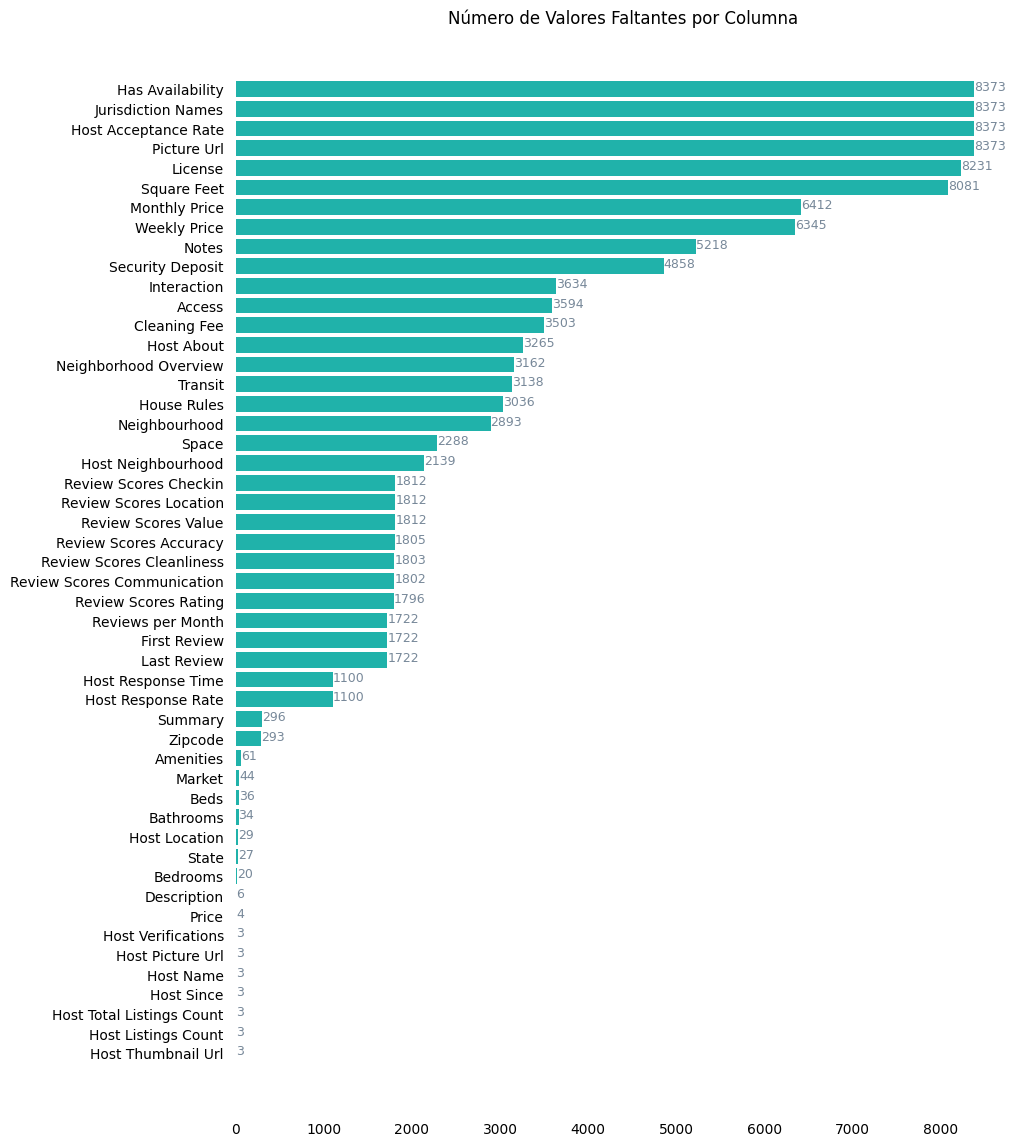

In [23]:
# Valores Faltantes en los datos
missing_values = data_madrid.isnull().sum()

# Filtramos las columnas que tienen valores faltantes, ordenados de mayor a menor
missing_values = missing_values[missing_values > 0].sort_values(ascending=True)
fig, ax = plt.subplots(figsize=(10, 14))

ax.barh(missing_values.index, missing_values.values, color='lightseagreen')

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Eliminamos x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Añadir padding entre ejes y etiquetas
ax.xaxis.set_tick_params(pad=5)
ax.yaxis.set_tick_params(pad=5)

# Valor barra
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize=9, fontweight='500',
             color='lightslategrey', va='center')

ax.set_title('Número de Valores Faltantes por Columna', fontsize=12, fontweight='500')
plt.show()

**Eliminación de Columnas con Todos los Valores Faltantes:** Observamos que las columnas `Has Availability, Picture Url, Host Acceptance Rate, Jurisdiction Names,` y `License` tienen todos sus valores faltantes. Estas columnas no proporcionan información útil para el modelado y se considera que pueden ser eliminadas.

Por otro lado se observan columnas con la **mayoría de Valores Faltantes** y columnas con **Información Redundante o Irrelevante**, por lo que vamos a crear una función para poder aplicar esta limpieza, más adelante en la etapa de **Preprocesamiento**, en todos los subconjuntos (`train`, `val` y `test`).

### Valores Únicos por Característica

In [24]:
data_madrid.nunique()

ID                                8373
Listing Url                       8373
Scrape ID                            1
Last Scraped                         1
Name                              8165
Summary                           7634
Space                             5708
Description                       8122
Experiences Offered                  1
Neighborhood Overview             4615
Notes                             2697
Transit                           4636
Access                            4199
Interaction                       3938
House Rules                       4651
Thumbnail Url                     8370
Medium Url                        8370
Picture Url                          0
XL Picture Url                    8370
Host ID                           5614
Host URL                          5614
Host Name                         2271
Host Since                        1886
Host Location                      392
Host About                        3082
Host Response Time       

### Distribución del Precio

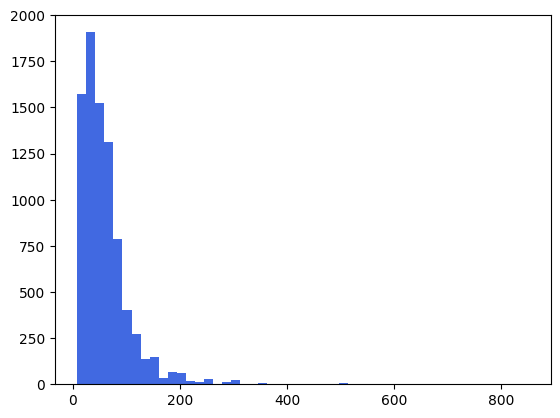

In [25]:
plt.hist(data_madrid['Price'], bins=50, color='royalblue')
plt.show()

# 4. Dividir los Datos en Train, Validación y Test y Guardar

In [42]:
labels = data_madrid['Price']
features = data_madrid.drop('Price', axis=1)

# Dividir el conjunto de datos
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Luego, dividir el conjunto de entrenamiento en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

Primero reservamos el 20% de los datos para el conjunto de prueba (test_size=0.2). Luego, del 80% restante, se reserva otro 25% para validación (test_size=0.25), lo que significa que el 20% del conjunto de datos original se usa para la validación y el 60% para el entrenamiento. Esto mantiene la proporción total de 60% entrenamiento, 20% validación y 20% prueba de los datos originales.

Creamos la carpeta `train_test_split` en Drive para guardar los siguientes archivos:

In [ ]:
# Guardar en Google Drive
X_train.to_csv('/content/drive/MyDrive/deep_learning/train_test_split/X_train.csv', index=False)
X_val.to_csv('/content/drive/MyDrive/deep_learning/train_test_split/X_val.csv', index=False)
X_test.to_csv('/content/drive/MyDrive/deep_learning/train_test_split/X_test.csv', index=False)
y_train.to_csv('/content/drive/MyDrive/deep_learning/train_test_split/y_train.csv', index=False)
y_val.to_csv('/content/drive/MyDrive/deep_learning/train_test_split/y_val.csv', index=False)
y_test.to_csv('/content/drive/MyDrive/deep_learning/train_test_split/y_test.csv', index=False)

In [26]:
# Carga los DataFrames desde los archivos CSV
X_train = pd.read_csv('/content/drive/MyDrive/deep_learning/train_test_split/X_train.csv')
X_val = pd.read_csv('/content/drive/MyDrive/deep_learning/train_test_split/X_val.csv')
X_test = pd.read_csv('/content/drive/MyDrive/deep_learning/train_test_split/X_test.csv')
y_train = pd.read_csv('/content/drive/MyDrive/deep_learning/train_test_split/y_train.csv')
y_val = pd.read_csv('/content/drive/MyDrive/deep_learning/train_test_split/y_val.csv')
y_test = pd.read_csv('/content/drive/MyDrive/deep_learning/train_test_split/y_test.csv')

In [27]:
# El dataset ya está dividido en train, validation y test. Vamos a ver las dimensiones:
print("El conjunto de entrenamiento tiene dimensiones: ", X_train.shape)
print("El conjunto de validación tiene dimensiones: ",X_val.shape)
print("El conjunto de test tiene dimensiones: ",X_test.shape)

# Hacemos lo mismo para las etiquetas:
print("El conjunto de entrenamiento (etiquetas) tiene dimensiones: ", y_train.shape)
print("El conjunto de validación (etiquetas) tiene dimensiones: ",y_val.shape)
print("El conjunto de test (etiquetas) tiene dimensiones: ",y_test.shape)

El conjunto de entrenamiento tiene dimensiones:  (5023, 88)
El conjunto de validación tiene dimensiones:  (1675, 88)
El conjunto de test tiene dimensiones:  (1675, 88)
El conjunto de entrenamiento (etiquetas) tiene dimensiones:  (5023, 1)
El conjunto de validación (etiquetas) tiene dimensiones:  (1675, 1)
El conjunto de test (etiquetas) tiene dimensiones:  (1675, 1)


In [28]:
# Comprobamos las columnas 'Zipcode', 'City' y 'State'
print(f"Valores únicos en 'Zipcode': {X_train['Zipcode'].unique()}")
print(f"Valores únicos en 'City': {X_train['City'].unique()}")
print(f"Valores únicos en 'State': {X_train['State'].unique()}")

Valores únicos en 'Zipcode': ['28039' '28012.0' '28038' '28002' '28005' '28001' '28012' '28056' '28013'
 '28026' '28003' '28035' '28004' '28008' '28005.0' '28014' '28015' '28011'
 '28036' '28009' '28020' '28029' '28045' '28013.0' '28045.0' '28007'
 '28004.0' '28002\n28002' '28018' '28043' '28010' '28030' '28028' nan
 '28051' '28007.0' '28046' '28037' '28006' '28009.0' '28019.0' '28047'
 '28019' '28025' '28011.0' '28041' '28024' '28017' '28033' '28008.0'
 '28021' '28016' '28042' '28053.0' '28035.0' '28023' '28053' '28027'
 '28017.0' '28014.0' '28031' '28054' '28022' '28024.0' '28850' '28032'
 '28050' '28034' '28044' '28028.0' '-' '28015.0' '28047.0' '28021.0'
 '28038.0' '28001.0' '28036.0' '28003.0' '28020.0' '28033.0' '280013'
 '28006.0' '2804' '28043.0' '28027.0' '28055.0' '20126' '28105' '28010.0'
 '25008' '28023.0' '28040' '28025.0' '28042.0' '28039.0' '28030.0' '28049'
 '2805' '28026.0' '28046.0' '28055' '28018.0' '28041.0' '28051.0' '2015.0'
 '28029.0' '28022.0' '28037.0' '28050.0

# 5. Limpiar Códigos Postales

In [29]:
def clean_zipcode(zipcode):
    if pd.isna(zipcode) or not isinstance(zipcode, str):
        return None
    zipcode = zipcode.replace('Madrid', '').strip()
    zipcode = ''.join(filter(str.isdigit, zipcode)).split('\n')[0]
    return zipcode if zipcode.startswith('28') and len(zipcode) == 5 else None

# Aplicar clean_zipcode a X_train
X_train['Zipcode'] = X_train['Zipcode'].apply(clean_zipcode)

# Aplicar clean_zipcode a X_val
X_val['Zipcode'] = X_val['Zipcode'].apply(clean_zipcode)

# Aplicar clean_zipcode a X_test
X_test['Zipcode'] = X_test['Zipcode'].apply(clean_zipcode)

In [30]:
# Comprobamos la columnas 'Zipcode'
print(f"Valores únicos en 'Zipcode': {X_train['Zipcode'].unique()}")

Valores únicos en 'Zipcode': ['28039' None '28038' '28002' '28005' '28001' '28012' '28056' '28013'
 '28026' '28003' '28035' '28004' '28008' '28014' '28015' '28011' '28036'
 '28009' '28020' '28029' '28045' '28007' '28018' '28043' '28010' '28030'
 '28028' '28051' '28046' '28037' '28006' '28047' '28019' '28025' '28041'
 '28024' '28017' '28033' '28021' '28016' '28042' '28023' '28053' '28027'
 '28031' '28054' '28022' '28850' '28032' '28050' '28034' '28044' '28105'
 '28040' '28049' '28055' '28058']


## Análisis Exploratorio en los Datos de Entrenamiento

In [31]:
X_train.describe()

,ID,Scrape ID,Picture Url,Host ID,Host Response Rate,Host Acceptance Rate,Host Listings Count,Host Total Listings Count,Latitude,Longitude,Accommodates,Bathrooms,Bedrooms,Beds,Square Feet,Weekly Price,Monthly Price,Security Deposit,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Has Availability,Availability 30,Availability 60,Availability 90,Availability 365,Number of Reviews,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,Jurisdiction Names,Calculated host listings count,Reviews per Month
count,5.023000e+03,5.023000e+03,0.0,5.023000e+03,4384.000000,0.0,5023.000000,5023.000000,5023.000000,5023.000000,5023.000000,5001.000000,5011.000000,5003.000000,178.000000,1207.000000,1176.000000,2107.000000,2919.000000,5023.000000,5023.000000,5023.000000,5023.000000,0.0,5023.000000,5023.000000,5023.000000,5023.000000,5023.000000,3942.000000,3936.000000,3936.000000,3928.000000,3937.000000,3929.000000,3930.000000,0.0,5023.000000,3989.000000
mean,1.074642e+07,2.017041e+13,NaN,3.899896e+07,95.835766,NaN,9.289269,9.289269,40.421069,-3.697067,3.037428,1.254849,1.269607,1.898261,309.376404,348.184756,1295.033163,178.295681,27.599520,1.536731,7.125622,2.451722,925.192116,NaN,8.336850,22.087597,38.891499,197.109496,24.251642,92.081684,9.457571,9.377795,9.658859,9.682499,9.533724,9.262595,NaN,7.010950,2.075382
std,5.484765e+06,0.000000e+00,NaN,3.510150e+07,13.081849,NaN,27.300957,27.300957,0.021002,0.024616,1.918540,0.624811,0.797797,1.429205,450.741748,178.087807,1116.939622,102.654203,19.854965,1.061526,9.764386,2.240251,2882.105883,NaN,8.850523,19.217754,29.030895,128.339999,39.054879,8.376022,0.859791,0.935427,0.724779,0.673452,0.779345,0.905429,NaN,17.861164,1.906578
min,2.151200e+04,2.017041e+13,NaN,1.985400e+04,0.000000,NaN,0.000000,0.000000,40.331888,-3.822403,1.000000,0.000000,0.000000,1.000000,0.000000,70.000000,275.000000,70.000000,4.000000,1.000000,0.000000,1.000000,1.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,NaN,1.000000,0.020000
25%,6.336351e+06,2.017041e+13,NaN,8.702962e+06,100.000000,NaN,1.000000,1.000000,40.410088,-3.708299,2.000000,1.000000,1.000000,1.000000,0.000000,200.000000,621.500000,100.000000,15.000000,1.000000,0.000000,1.000000,360.000000,NaN,0.000000,4.000000,11.000000,73.000000,1.000000,89.000000,9.000000,9.000000,9.000000,10.000000,9.000000,9.000000,NaN,1.000000,0.580000
50%,1.200857e+07,2.017041e+13,NaN,2.855951e+07,100.000000,NaN,2.000000,2.000000,40.418948,-3.701725,2.000000,1.000000,1.000000,1.000000,50.000000,320.000000,1120.000000,150.000000,25.000000,1.000000,0.000000,2.000000,1125.000000,NaN,6.000000,19.000000,36.000000,224.000000,8.000000,94.000000,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000,NaN,2.000000,1.500000
75%,1.559548e+07,2.017041e+13,NaN,6.119607e+07,100.000000,NaN,4.000000,4.000000,40.428906,-3.693496,4.000000,1.000000,1.000000,2.000000,538.000000,450.000000,1600.000000,200.000000,33.000000,2.000000,12.000000,3.000000,1125.000000,NaN,13.000000,37.000000,63.000000,316.000000,30.000000,98.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,4.000000,3.060000
max,1.810858e+07,2.017041e+13,NaN,1.247388e+08,100.000000,NaN,207.000000,207.000000,40.513552,-3.573613,16.000000,8.000000,10.000000,16.000000,2691.000000,980.000000,25000.000000,900.000000,200.000000,15.000000,276.000000,26.000000,100000.000000,NaN,30.000000,60.000000,90.000000,365.000000,343.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,145.000000,13.600000


### Visualización con Histogramas

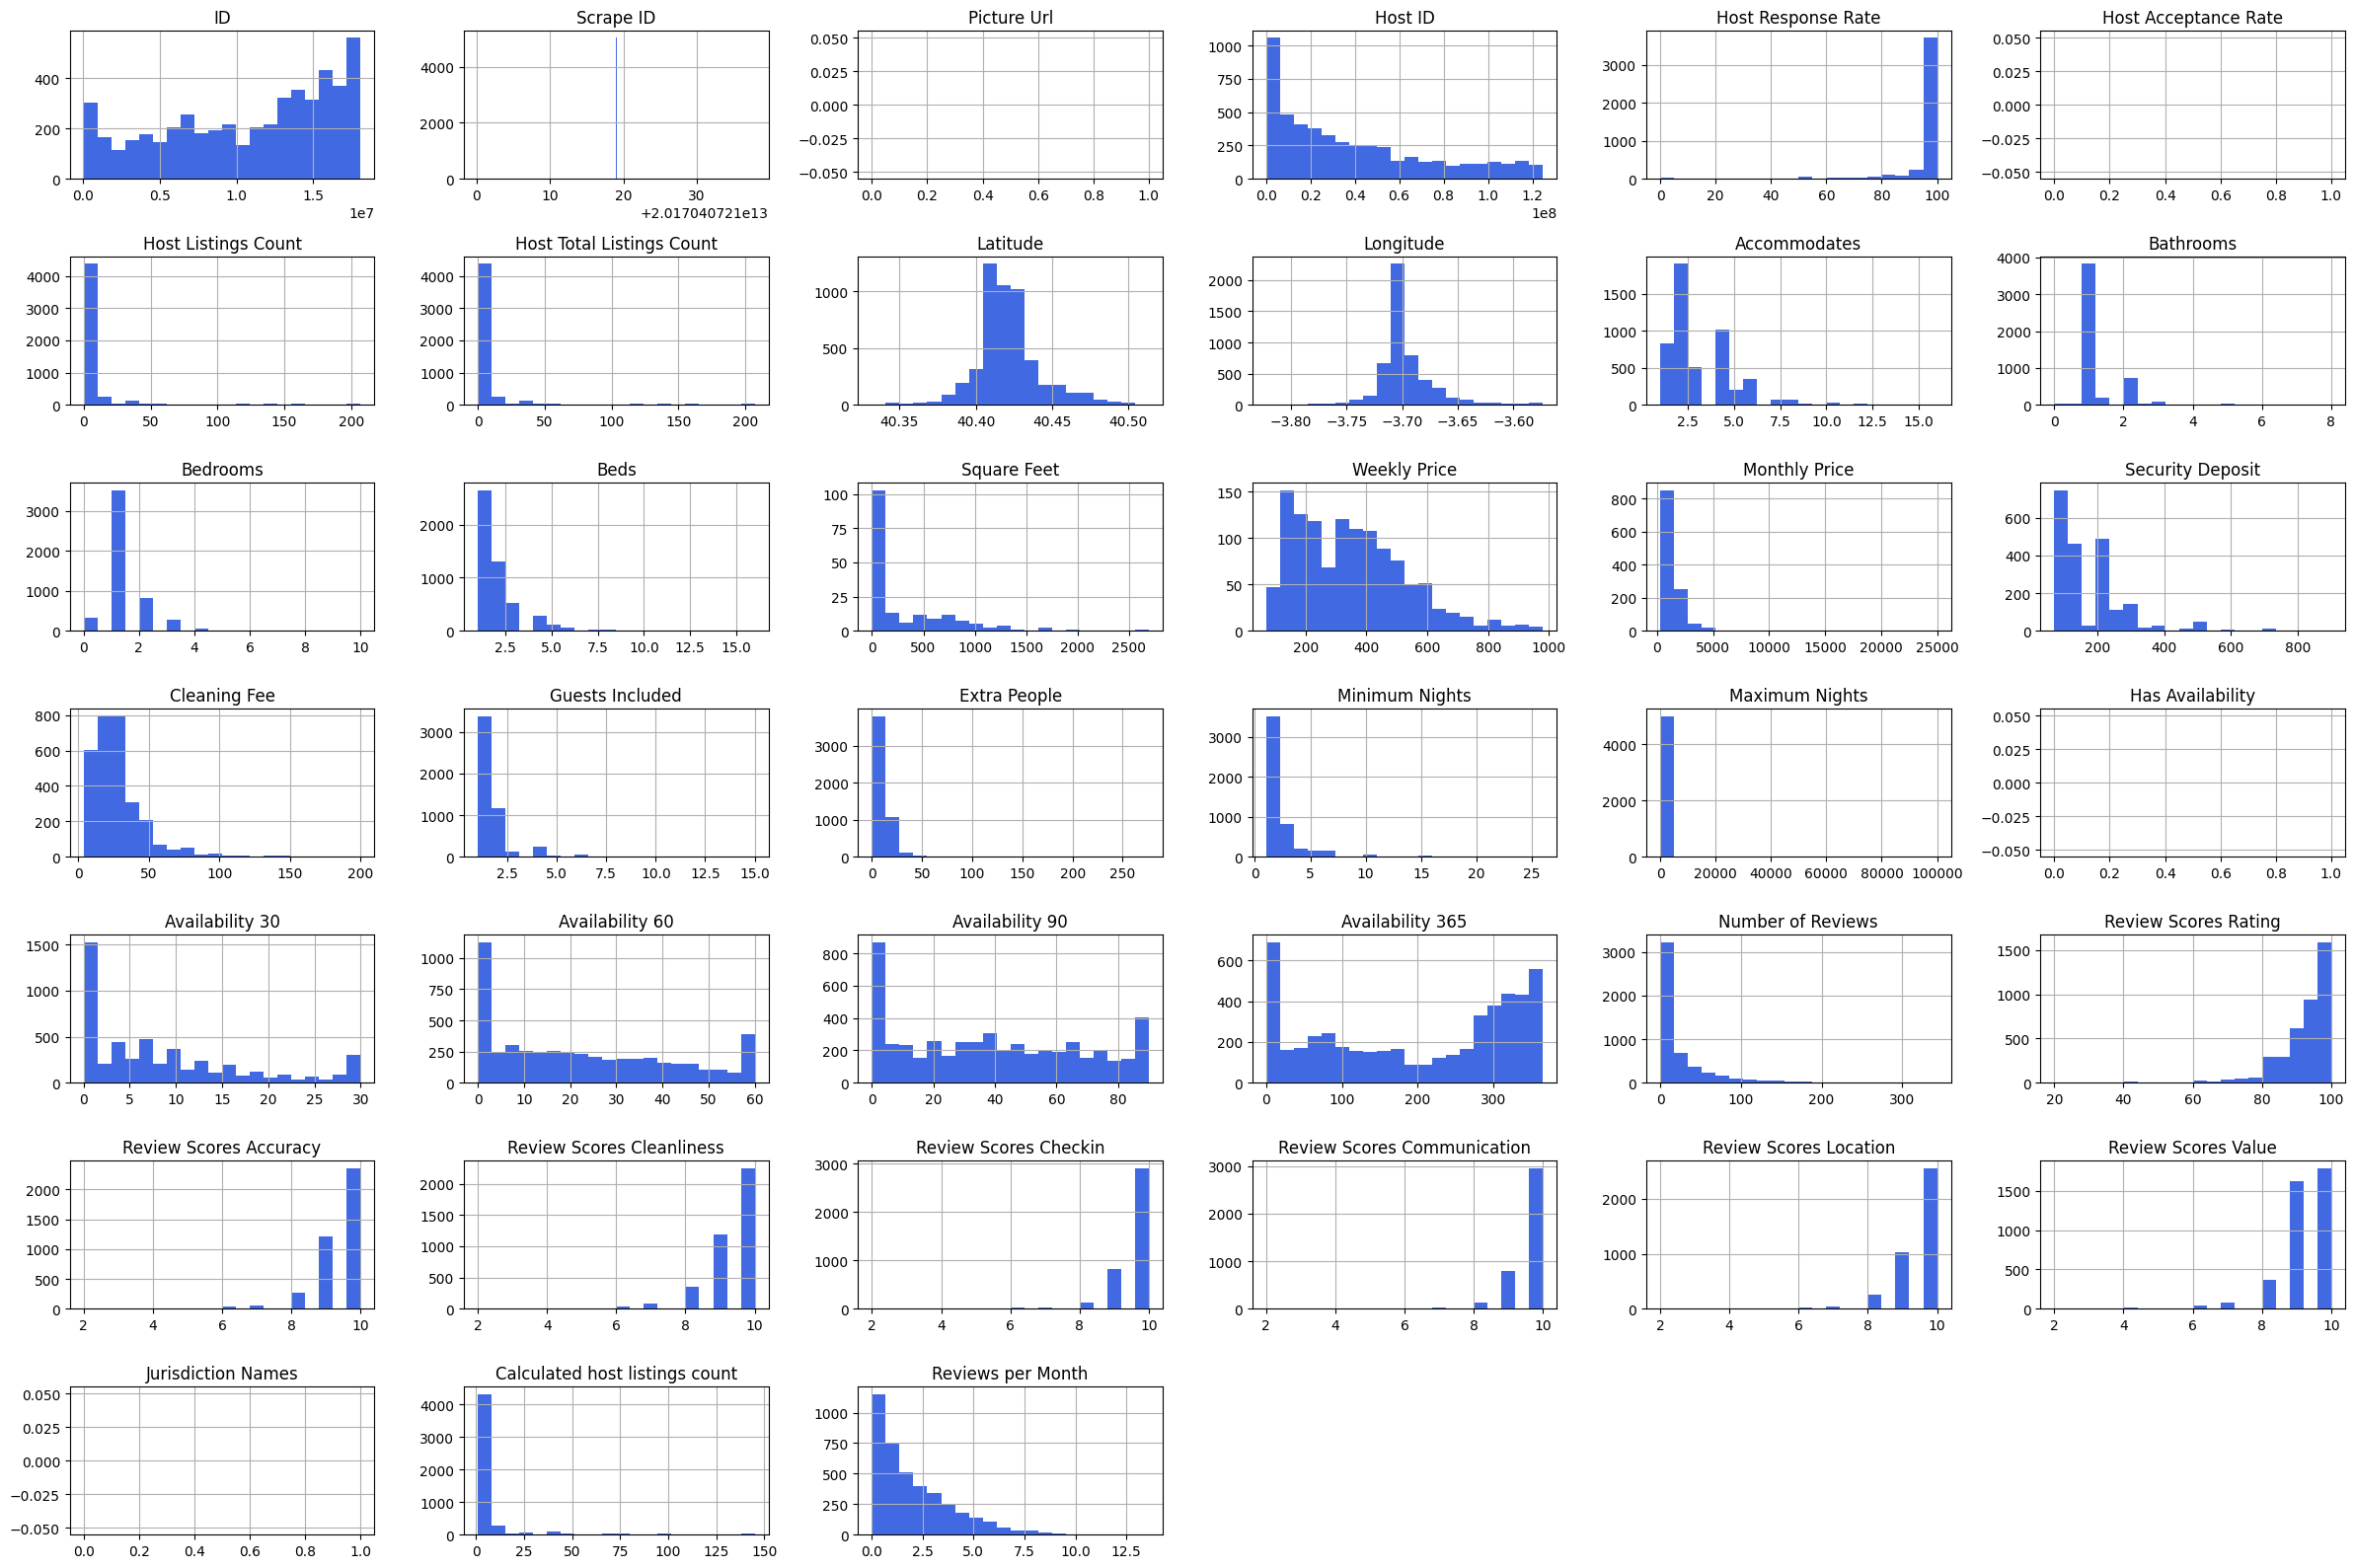

In [35]:
X_train.hist(bins=20, figsize=(24,16), color='royalblue')
plt.tight_layout()
plt.show()

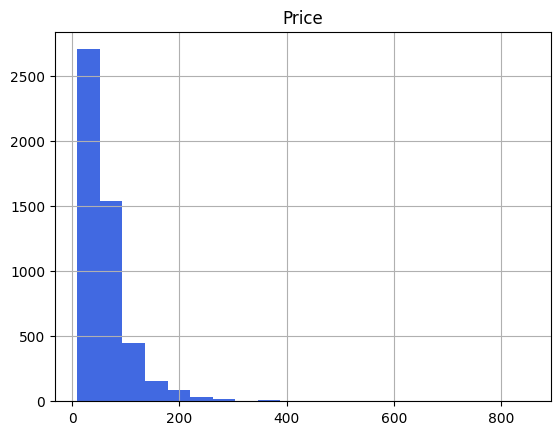

In [37]:
y_train.hist(bins=20, color='royalblue')
plt.show()

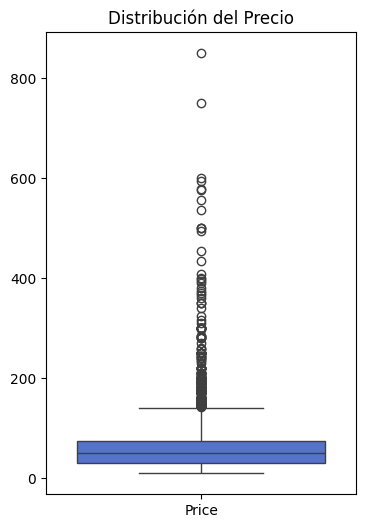

In [39]:
plt.figure(figsize=(4, 6))
sns.boxplot(y_train, color='royalblue')
plt.title('Distribución del Precio')
plt.show()

Aunque se observan outliers, decidimos mantenerlos porque se considera que representan aspectos reales del conjunto de datos. Esto se tendrá en cuenta a la hora de utilizar modelos que sean más robuscos a outliers, como árboles de decisión o ensambles basados en árboles (por ejemplo, Random Forest o Gradient Boosting), que manejan mejor los outliers.

# 6. Análisis de la correlación

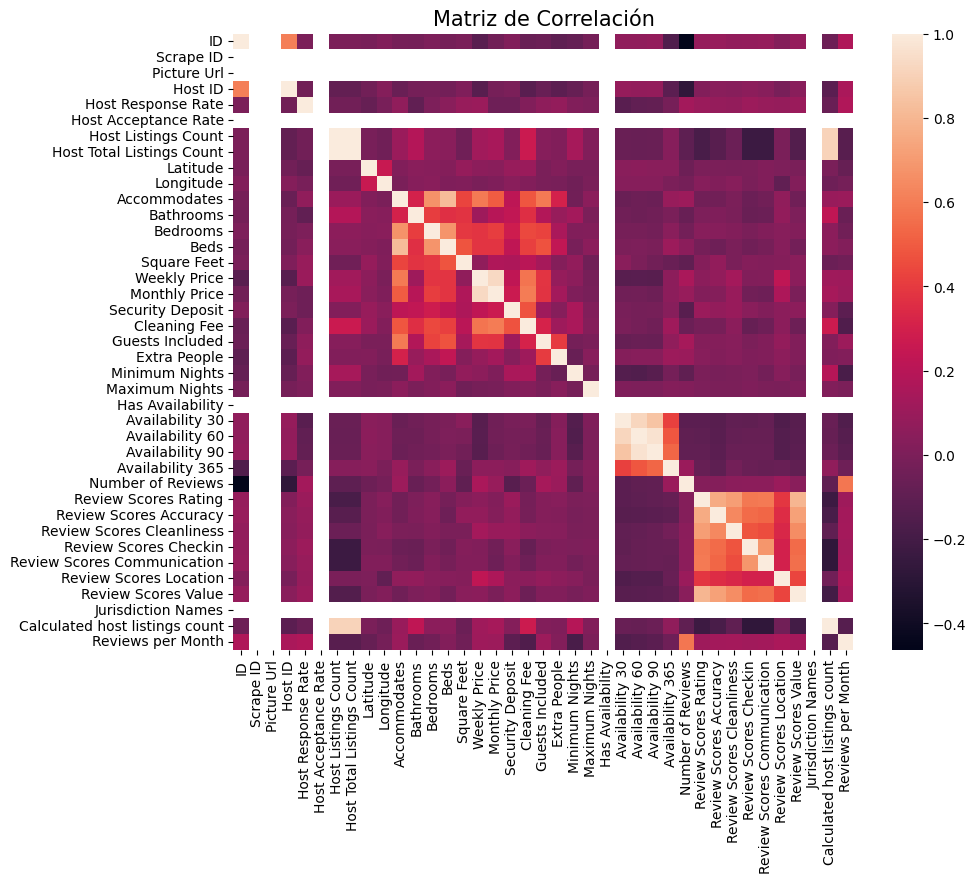

In [40]:
# Calculamos la matriz de correlación para data_train
corr_matrix = X_train.select_dtypes(include=[np.number]).corr()

# Gráfico de calor para la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix)
plt.title('Matriz de Correlación', fontsize=15)
plt.show()

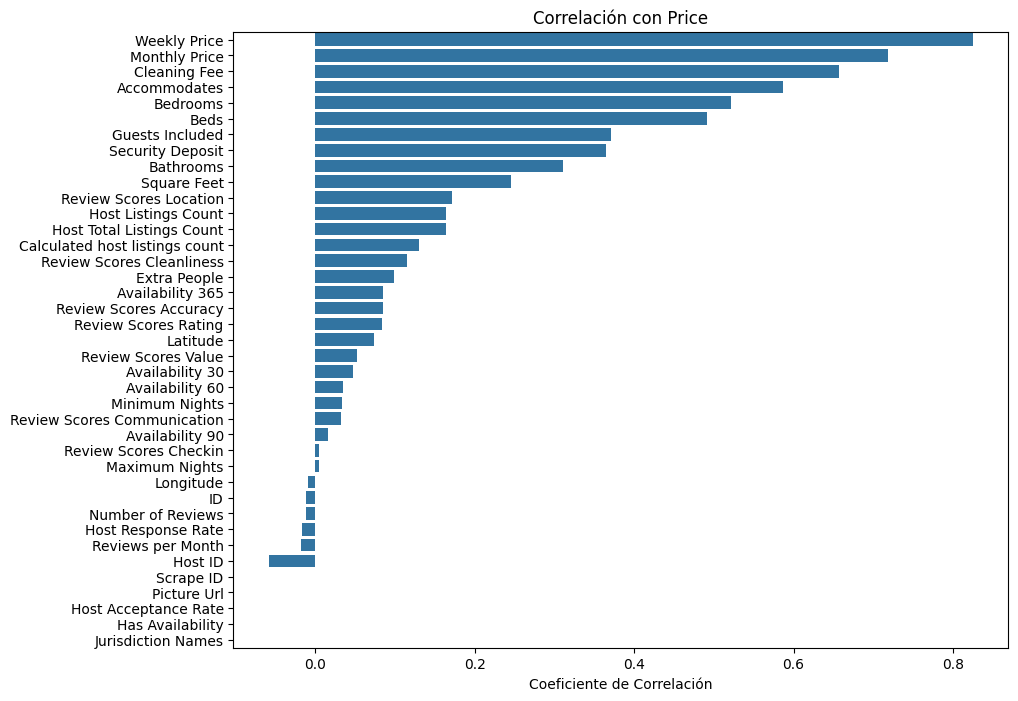

In [44]:
# Creamos un DataFrame temporal para el análisis de correlación
temp_df = features.copy()
temp_df['Price'] = labels

# Calculamos la matriz de correlación
corr_matrix = temp_df.corr(numeric_only=True)

# Obtenemos las correlaciones de 'Price' con las demás, excluyendo su propia correlación
corr_with_price = corr_matrix["Price"].sort_values(ascending=False).drop('Price')

# Visualizamos las correlaciones con 'Price'
plt.figure(figsize=(10, 8))
sns.barplot(x=corr_with_price.values, y=corr_with_price.index)
plt.title('Correlación con Price', fontsize=12)
plt.xlabel('Coeficiente de Correlación')
plt.ylabel('')
plt.show()

# 7. Preprocesamiento

- Generación de nuevas variables
- Limpieza de características
- Filtrado de datos
- Codificación de características de texto o categóricas
- Imputar datos faltantes
- Normalización y Estandarización

## Generación de nuevas variables

Para enriquecer nuestro análisis y potenciar el modelo predictivo, generamos nuevas variables derivadas de los datos existentes:

- LatLong (multiplicacion de longitude y latitude)
- BedsPerRoom (nº camas / nº habitaciones) - Relación Dormitorios-Camas
- BathsPerRoom (nº baños / nº habitaciones) - Relación Baños-Habitaciones
- BedBathRooms (nº dormitorios * nº baños) - Relación Dormitorios-Baños
- Stay Duration (duración de la estancia en base a minimum nights y maximum nights)

In [45]:
# Creamos una columna que refleje la duración de la estancia
def classify_stay(min_nights, max_nights):
    if min_nights == 1 and max_nights <= 7:
        return 1  # Estancias cortas
    elif 7 < min_nights <= 30 or (min_nights <= 7 and 7 < max_nights <= 30):
        return 2  # Estancias medias
    elif 30 < min_nights <= 365 or (min_nights <= 30 and 30 < max_nights <= 365):
        return 3  # Estancias largas
    elif min_nights > 365 or max_nights > 365:
        return 4  # Estancias muy largas
    else:
        return 0  # Casos atípicos o no clasificables

In [46]:
def apply_transformations(df):
    # Creación de nuevas características
    df['LatLong'] = df['Latitude'] * df['Longitude']
    df['BedsPerRoom'] = df.apply(lambda row: row['Beds'] / row['Bedrooms'] if row['Bedrooms'] > 0 else 0, axis=1)
    df['BathsPerRoom'] = df.apply(lambda row: row['Bathrooms'] / row['Bedrooms'] if row['Bedrooms'] > 0 else 0, axis=1)
    df['BedBathRooms'] = df['Bedrooms'] * df['Bathrooms']
    df['Stay Duration'] = df.apply(lambda row: classify_stay(row['Minimum Nights'], row['Maximum Nights']), axis=1)
    # Devolve el DataFrame modificado
    return df

# Aplicamos las transformaciones a X_train, X_val y X_test
X_train = apply_transformations(X_train)
X_val = apply_transformations(X_val)
X_test = apply_transformations(X_test)

In [47]:
print(X_train[['LatLong','BedsPerRoom','BathsPerRoom','BedBathRooms']].describe())

           LatLong  BedsPerRoom  BathsPerRoom  BedBathRooms
count  5023.000000  5009.000000   5001.000000   4989.000000
mean   -149.439250     1.327347      0.972806      1.798958
std       0.978169     0.862002      0.591232      2.540386
min    -154.699346     0.000000      0.000000      0.000000
25%    -149.891044     1.000000      1.000000      1.000000
50%    -149.622965     1.000000      1.000000      1.000000
75%    -149.269455     2.000000      1.000000      2.000000
max    -144.529983    16.000000      8.000000     65.000000


In [48]:
print(X_train[['Stay Duration', 'Minimum Nights', 'Maximum Nights']].describe())

       Stay Duration  Minimum Nights  Maximum Nights
count    5023.000000     5023.000000     5023.000000
mean        3.422059        2.451722      925.192116
std         1.005286        2.240251     2882.105883
min         0.000000        1.000000        1.000000
25%         3.000000        1.000000      360.000000
50%         4.000000        2.000000     1125.000000
75%         4.000000        3.000000     1125.000000
max         4.000000       26.000000   100000.000000


In [49]:
print(X_train[['Stay Duration']].value_counts())

Stay Duration
4                3518
2                 719
3                 509
1                 152
0                 125
dtype: int64


## Limpieza de características

Implementamos una función para eliminar columnas que no contribuyen significativamente al poder predictivo del modelo o que contienen una alta proporción de valores faltantes. Las columnas eliminadas incluyen URLs, información del host, datos geográficos redundantes, y variables altamente específicas que no son generalizables.

### Función de Limpieza de Características

In [50]:
def drop_columns(df, columns_to_drop):
    """
    Elimina las columnas especificadas de un DataFrame.

    Parámetros:
    - df (pandas.DataFrame): DataFrame del cual se eliminarán las columnas.
    - columnas_a_eliminar (list): Lista de nombres de columnas a eliminar.

    Retorna:
    - Un nuevo DataFrame sin las columnas especificadas.
    """
    # Hacer una copia del DataFrame para evitar modificar el original
    clean_df = df.copy()
    # Eliminar las columnas
    clean_df = clean_df.drop(columns=columns_to_drop)
    return clean_df

In [51]:
# Lista de columnas a eliminar
columns_to_drop = ['Listing Url','Scrape ID','Last Scraped','Calendar last Scraped',
                   'Has Availability','Picture Url','Host Acceptance Rate','Jurisdiction Names','License','Square Feet','Bed Type','Cleaning Fee','Features',
                   'Name','Summary','Space','Description','Notes','Neighborhood Overview','Transit','Access','Neighbourhood Cleansed','Neighbourhood Group Cleansed',
                   'Interaction','House Rules','Medium Url','Picture Url','XL Picture Url','Host Thumbnail Url','Host Picture Url',
                   'Host ID','Host Name','Host Location','Host Neighbourhood','Host About','Host Listings Count','Experiences Offered','Host Response Rate','Host Since',
                   'Host Response Time','Host Verifications','Host Listings Count','Host ID','Host URL','Geolocation','Weekly Price','Monthly Price',
                   'Neighbourhood','Street','City','State','Country Code','Country','Market','Smart Location','Latitude','Longitude','Zipcode',
                   'Availability 30','Availability 60','Availability 90','Availability 365', 'Minimum Nights','Maximum Nights','Calendar Updated','Security Deposit',
                   'Review Scores Rating','Review Scores Accuracy','Review Scores Cleanliness','Review Scores Checkin','Review Scores Communication',
                   'First Review','Last Review','Review Scores Location','Review Scores Value','Reviews per Month','Calculated host listings count']

# Aplicar la función a los conjuntos de entrenamiento, prueba y validación
X_train = drop_columns(X_train, columns_to_drop)
X_test = drop_columns(X_test, columns_to_drop)
X_val = drop_columns(X_val, columns_to_drop)

## Comprobación de Correlación

Analizamos la correlación entre las variables numéricas para identificar relaciones fuertes que podrían influir en el precio. Este análisis nos ayudó a seleccionar características relevantes para el modelo y a descartar variables redundantes o poco informativas.

In [52]:
# Calculamos la matriz de correlación para las características numéricas en X_train
corr_matrix = X_train.select_dtypes(include=[np.number]).corr()

# Buscamos correlaciones fuertes entre las características, por ejemplo:
strong_corr_pairs = corr_matrix.unstack().sort_values(ascending=False).drop_duplicates()
strong_corr_pairs = strong_corr_pairs[(strong_corr_pairs > 0.4) | (strong_corr_pairs < -0.4)]

# Filtramos para evitar mostrar la correlación de una variable consigo misma
strong_corr_pairs = strong_corr_pairs[strong_corr_pairs < 1]

print(strong_corr_pairs)

Beds               Accommodates       0.819501
Bedrooms           BedBathRooms       0.787765
BedBathRooms       Bathrooms          0.704618
Beds               Bedrooms           0.677890
Accommodates       Bedrooms           0.673381
Bathrooms          BathsPerRoom       0.630850
BedsPerRoom        Beds               0.607642
BedBathRooms       Beds               0.596272
Guests Included    Accommodates       0.589096
Accommodates       BedBathRooms       0.548698
Guests Included    Beds               0.473443
Bedrooms           Guests Included    0.425841
                   Bathrooms          0.408897
Extra People       Guests Included    0.400919
Number of Reviews  ID                -0.462138
dtype: float64


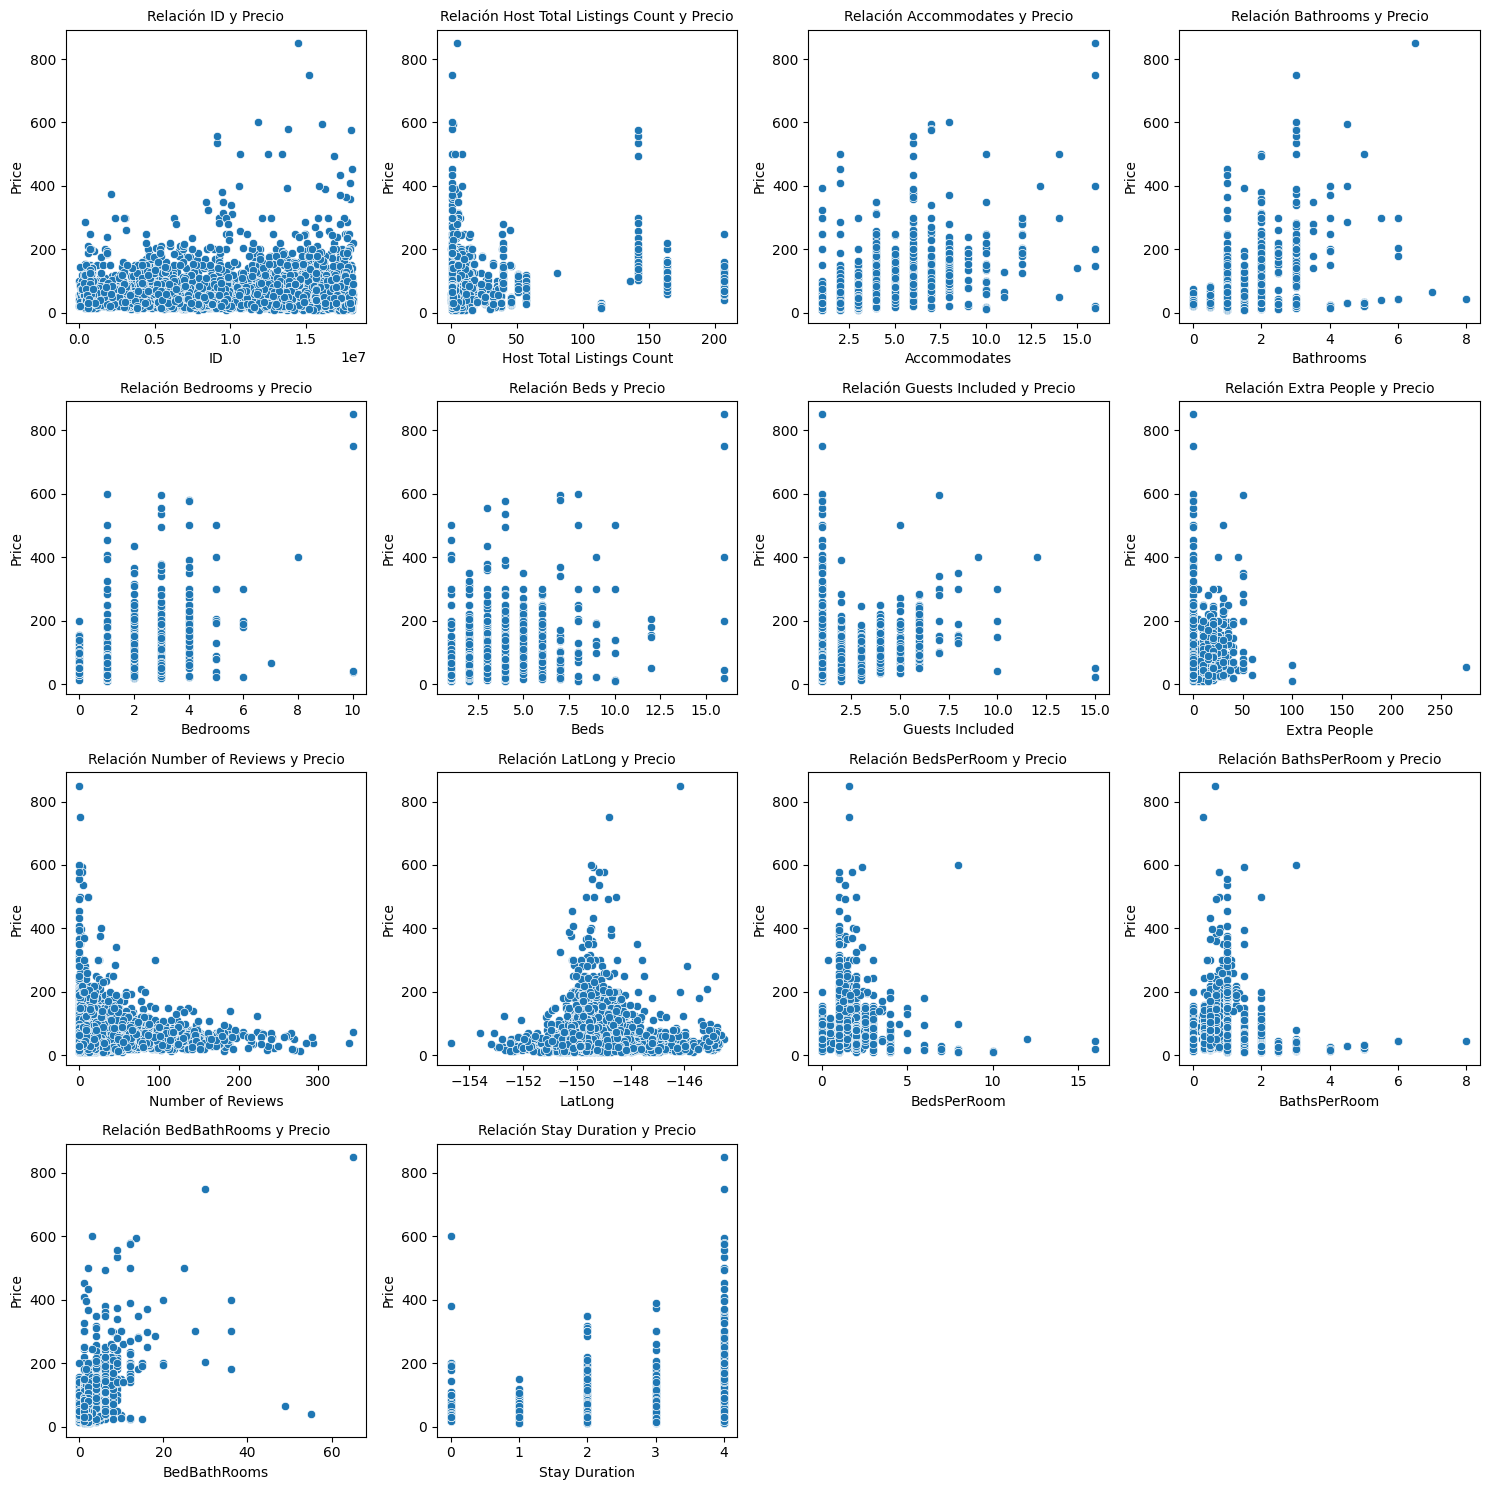

In [54]:
# Calculamos el número de filas/columnas para la cuadrícula de gráficos.
# Usaremos raíz cuadrada del número de columnas para una distribución uniforme.
num_columns = X_train.select_dtypes(include=[np.number]).columns.size
grid_size = int(np.ceil(np.sqrt(num_columns)))

# Crear una figura y un conjunto de subgráficos en forma de cuadrícula
fig, axs = plt.subplots(nrows=grid_size, ncols=grid_size, figsize=(15, 15))

# Aplanamos el array de los ejes para facilitar su uso en un bucle.
axs = axs.flatten()

# Graficamos cada característica numérica en su propio subgráfico.
for i, column in enumerate(X_train.select_dtypes(include=[np.number]).columns):
    sns.scatterplot(ax=axs[i], x=X_train[column], y=y_train.squeeze())  # Nos aseguramos de que y_train sea unidimensional
    axs[i].set_title(f'Relación {column} y Precio', fontsize=10)
    axs[i].set_xlabel(column)
    axs[i].set_ylabel('Price')

# Ocultamos los subgráficos vacíos si los hay.
for i in range(num_columns, len(axs)):
    axs[i].set_visible(False)

# Ajuste de la visualización
plt.tight_layout()
plt.show()

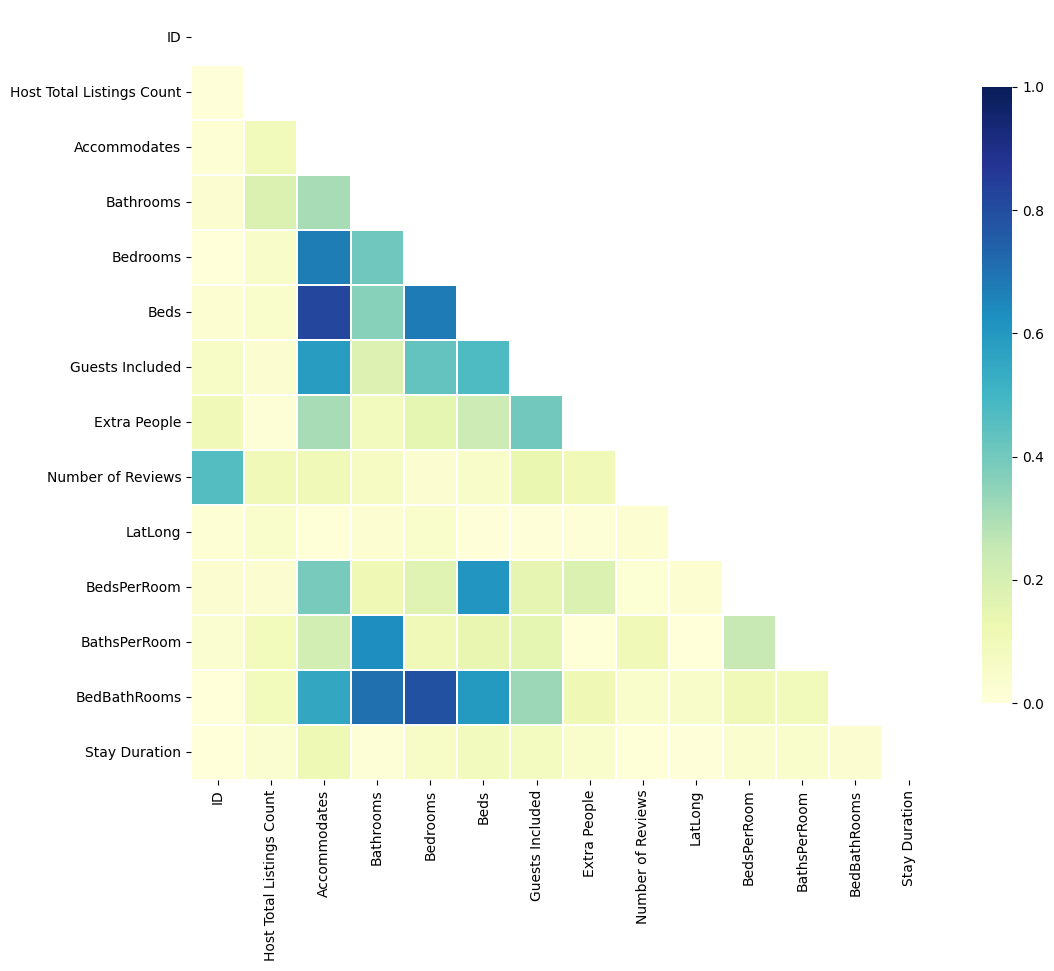

In [53]:
# Seleccionamos solo las columnas numéricas para el análisis de correlación.
data = X_train.select_dtypes(include=[np.number])

# Calculamos la matriz de correlación.
corr = np.abs(data.corr())

# Preparamos una máscara para ocultar la parte superior de la matriz de correlación, para evitar duplicados.
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Configuramos el tamaño de la figura.
f, ax = plt.subplots(figsize=(12, 10))

# Dibujamos el mapa de calor con la máscara.
sns.heatmap(corr, mask=mask, vmin=0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

## Filtrado de Datos

Se excluyen del análisis los alojamientos con:
- Más de 8 dormitorios
- Más de 7 baños
- 0 baños
- Más de 6 dormitorios y que tengan menos de 4 camas

Excluimos alojamientos con características extremas (como un número excesivo de dormitorios o baños) para evitar sesgos en el modelo. Este filtrado asegura que el modelo se entrene con datos representativos de la mayoría de los alojamientos.

In [55]:
# Antes de hacer este filtrado vamos a comprobar las dimensiones

# Dimensiones iniciales de los conjuntos de datos
print("Dimensiones iniciales:")
print("Train:", X_train.shape)
print("Validation:", X_val.shape)
print("Test:", X_test.shape)

# Suma de las dimensiones de los conjuntos de datos
total_data_size_before = len(X_train) + len(X_val) + len(X_test)
print("Total registros (Train + Val + Test):", total_data_size_before)

Dimensiones iniciales:
Train: (5023, 19)
Validation: (1675, 19)
Test: (1675, 19)
Total registros (Train + Val + Test): 8373


In [56]:
# Filtramos posibles outliers
def filter_data_and_get_removed_indices(data):
    # Guardamos los índices iniciales
    initial_indices = set(data.index)

    # Aplicamos las condiciones de filtrado
    condition = ~((data['Bedrooms'] > 6) & (data['Beds'] < 4))
    condition &= (data['Bedrooms'] <= 8)
    condition &= (data['Bathrooms'] <= 6) & (data['Bathrooms'] > 0)

    # Filtramos los datos
    filtered_data = data[condition]
    filtered_indices = set(filtered_data.index)  # Índices después del filtrado

    # Calculamos los índices removidos
    removed_indices = initial_indices - filtered_indices

    return filtered_data, removed_indices

X_train_filtered, train_removed_indices = filter_data_and_get_removed_indices(X_train)
X_val_filtered, val_removed_indices = filter_data_and_get_removed_indices(X_val)
X_test_filtered, test_removed_indices = filter_data_and_get_removed_indices(X_test)

# Aplicamos el filtro a las etiquetas 'y' usando los índices de los datos filtrados
y_train = y_train.loc[X_train_filtered.index]
y_val = y_val.loc[X_val_filtered.index]
y_test = y_test.loc[X_test_filtered.index]

In [57]:
# Antes de hacer este filtrado vamos a comprobar las dimensiones

# Dimensiones iniciales de los conjuntos de datos
print("Dimensiones iniciales:")
print("Train:", X_train_filtered.shape)
print("Validation:", X_val_filtered.shape)
print("Test:", X_test_filtered.shape)

# Suma de las dimensiones de los conjuntos de datos
total_data_size_after = len(X_train_filtered) + len(X_val_filtered) + len(X_test_filtered)
print("Total registros (Train + Val + Test):", total_data_size_after)

Dimensiones iniciales:
Train: (4954, 19)
Validation: (1654, 19)
Test: (1658, 19)
Total registros (Train + Val + Test): 8266


## Descarga de imágenes y Guardado

Desarrollamos un proceso para descargar imágenes de los alojamientos, ajustando su tamaño para estandarizar el input al modelo. Este paso fue crucial para preparar los datos para un modelo basado en imágenes, permitiendo que el modelo visualice y aprenda de las características visuales de los alojamientos.

In [ ]:
# Llamada a download_images para el conjunto de entrenamiento
imagenes_train, ids_train, _ = download_images(
    paths=X_train_filtered['Thumbnail Url'].values,
    ids=X_train_filtered['ID'].values,
    canvas=(224, 224),
    nb_channels=3
)

# Repetimos el proceso para los conjuntos de validación y test
imagenes_val, ids_val, _ = download_images(
    paths=X_val_filtered['Thumbnail Url'].values,
    ids=X_val_filtered['ID'].values,
    canvas=(224, 224),
    nb_channels=3
)

imagenes_test, ids_test, _ = download_images(
    paths=X_test_filtered['Thumbnail Url'].values,
    ids=X_test_filtered['ID'].values,
    canvas=(224, 224),
    nb_channels=3
)

100%|██████████| 1658/1658 [11:29<00:00,  2.40it/s]


In [ ]:
# Combinar los arrays de imágenes en un solo array
imagenes_combinadas = np.concatenate([imagenes_train, imagenes_val, imagenes_test], axis=0)

In [ ]:
print(imagenes_combinadas.shape)

(8266, 224, 224, 3)


In [ ]:
# Guardar el array de imágenes combinadas en un archivo .npy
np.save('/content/drive/My Drive/deep_learning/imagenes_procesadas.npy', imagenes_combinadas)

In [ ]:
np.save('/content/drive/My Drive/deep_learning/imagenes_train.npy', imagenes_train)
np.save('/content/drive/My Drive/deep_learning/imagenes_val.npy', imagenes_val)
np.save('/content/drive/My Drive/deep_learning/imagenes_test.npy', imagenes_test)

In [ ]:
# Cargar el array de imágenes desde el archivo .npy
imagenes_cargadas = np.load('/content/drive/My Drive/deep_learning/imagenes_procesadas.npy')

In [ ]:
imagenes_train = np.load('/content/drive/My Drive/deep_learning/imagenes_train.npy')
imagenes_val = np.load('/content/drive/My Drive/deep_learning/imagenes_val.npy')
imagenes_test = np.load('/content/drive/My Drive/deep_learning/imagenes_test.npy')

In [ ]:
print(imagenes_cargadas.shape)

(8266, 224, 224, 3)


## Eliminamos las columnas 'ID' y 'Thumbnail Url' tras la descarga de las imágenes



In [ ]:
# Segunda lista de columnas a eliminar
columns_to_drop_2 = ['ID','Thumbnail Url']

# Aplicar la función a los conjuntos de entrenamiento, prueba y validación
X_train_filtered = drop_columns(X_train_filtered, columns_to_drop_2)
X_test_filtered = drop_columns(X_test_filtered, columns_to_drop_2)
X_val_filtered = drop_columns(X_val_filtered, columns_to_drop_2)

In [ ]:
# Comprobación
print(X_train_filtered.columns)
print(f"Total registros (Train + Val + Test): {len(X_train_filtered) + len(X_val_filtered) + len(X_test_filtered)}")

Index(['Host Total Listings Count', 'Property Type', 'Room Type',
       'Accommodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Amenities',
       'Guests Included', 'Extra People', 'Number of Reviews',
       'Cancellation Policy', 'LatLong', 'BedsPerRoom', 'BathsPerRoom',
       'BedBathRooms', 'Stay Duration'],
      dtype='object')
Total registros (Train + Val + Test): 8266


In [ ]:
# Reasignamos
X_train = X_train_filtered
X_val = X_val_filtered
X_test = X_test_filtered

In [ ]:
# Última verificación
print("Dimensiones actuales tras el filtrado:")
print("Train:", X_train.shape)
print("Validation:", X_val.shape)
print("Test:", X_test.shape)
print(f"Total registros (Train + Val + Test): {len(X_train) + len(X_val) + len(X_test)}")

Dimensiones actuales tras el filtrado:
Train: (4954, 17)
Validation: (1654, 17)
Test: (1658, 17)
Total registros (Train + Val + Test): 8266


## Codificación de características de texto o categóricas

Convertimos las variables categóricas en formatos numéricos para que puedan ser procesadas por el modelo. Esto incluye técnicas como *Ordinal Encoding* o *Mean Encoding*, dependiendo de la naturaleza de la variable.

Se hizo una prueba con *get_dummies* en las columnas `Property Type` y `Room Type` pero no se obtuvieron buenos resultados.

In [ ]:
# Conocer el promedio de precios para luego hacer Mean Encoder
#mean_price = data_madrid['Price'].mean()
mean_price = 61.89437208746565 # mismo valor que el anterior, para no volver a cargar data_madrid
print("Promedio general de precios:", mean_price)

Promedio general de precios: 61.89437208746565


In [ ]:
from sklearn.preprocessing import OrdinalEncoder

# Cuenta los elementos separados por comas
def count_comma_separated_items(item):
    if pd.isna(item) or item == 'nan':
        return 0  # Retorna 0 si el valor es NaN o la cadena 'nan'
    else:
        return len(item.split(','))

X_train['Amenities'] = X_train['Amenities'].astype(str).apply(count_comma_separated_items)
X_val['Amenities'] = X_val['Amenities'].astype(str).apply(count_comma_separated_items)
X_test['Amenities'] = X_test['Amenities'].astype(str).apply(count_comma_separated_items)

# Función para agrupar las categorías de 'Property Type'
def group_property_type(property_type):
    categories_to_keep = ['Apartment', 'House', 'Condominium', 'Bed & Breakfast', 'Loft']
    if property_type in categories_to_keep:
        return property_type
    else:
        return 'Others'

X_train['Property Type'] = X_train['Property Type'].apply(group_property_type)
X_val['Property Type'] = X_val['Property Type'].apply(group_property_type)
X_test['Property Type'] = X_test['Property Type'].apply(group_property_type)

# Combinamos X_train con y_train para la codificación de media
train_data = pd.concat([X_train, y_train], axis=1)

# Aplicar codificación de media a 'Property Type' en X_train
mean_encoded = train_data.groupby('Property Type')['Price'].mean()
X_train['Property Type'] = X_train['Property Type'].map(mean_encoded)
X_val['Property Type'] = X_val['Property Type'].map(mean_encoded)
X_test['Property Type'] = X_test['Property Type'].map(mean_encoded)

# Aplicar codificación de media a 'Room Type' en X_train
mean_encoded = train_data.groupby('Room Type')['Price'].mean()
X_train['Room Type'] = X_train['Room Type'].map(mean_encoded)
X_val['Room Type'] = X_val['Room Type'].map(mean_encoded)
X_test['Room Type'] = X_test['Room Type'].map(mean_encoded)

# Agrupamos categorías 'super_strict_60' y 'super_strict_30' como 'super_strict'
X_train['Cancellation Policy'] = X_train['Cancellation Policy'].replace(['super_strict_60', 'super_strict_30'], 'super_strict')
X_val['Cancellation Policy'] = X_val['Cancellation Policy'].replace(['super_strict_60', 'super_strict_30'], 'super_strict')
X_test['Cancellation Policy'] = X_test['Cancellation Policy'].replace(['super_strict_60', 'super_strict_30'], 'super_strict')

# Definimos las categorías en el orden desearo para la codificación ordinal
categories = [['flexible', 'moderate', 'strict', 'super_strict']]

# Creamos el OrdinalEncoder con las categorías definidas
ordinal_encoder = OrdinalEncoder(categories=categories)

# Aplicamos el ajuste y la transformación a 'Cancellation Policy'
X_train['Cancellation Policy'] = ordinal_encoder.fit_transform(X_train[['Cancellation Policy']])
X_val['Cancellation Policy'] = ordinal_encoder.transform(X_val[['Cancellation Policy']])
X_test['Cancellation Policy'] = ordinal_encoder.transform(X_test[['Cancellation Policy']])

In [ ]:
X_train[['Property Type','Room Type']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4954 entries, 0 to 4953
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Property Type  4954 non-null   float64
 1   Room Type      4954 non-null   float64
dtypes: float64(2)
memory usage: 77.5 KB


In [ ]:
# Verificamos que todas las categorías son numéricas
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4954 entries, 0 to 4953
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Host Total Listings Count  4954 non-null   float64
 1   Property Type              4954 non-null   float64
 2   Room Type                  4954 non-null   float64
 3   Accommodates               4954 non-null   int64  
 4   Bathrooms                  4954 non-null   float64
 5   Bedrooms                   4954 non-null   float64
 6   Beds                       4950 non-null   float64
 7   Amenities                  4954 non-null   int64  
 8   Guests Included            4954 non-null   int64  
 9   Extra People               4954 non-null   int64  
 10  Number of Reviews          4954 non-null   int64  
 11  Cancellation Policy        4954 non-null   float64
 12  LatLong                    4954 non-null   float64
 13  BedsPerRoom                4950 non-null   float

## Imputar Datos Faltantes

Utilizamos `KNNImputer` para tratar los valores faltantes, una técnica que estima los valores ausentes basándose en los vecinos más cercanos. Esto nos permite mantener la integridad de nuestro dataset sin descartar registros valiosos.

In [ ]:
# Unir temporalmente los DataFrames para identificar todas las columnas con valores faltantes
all_data_temp = pd.concat([X_train, X_val, X_test])

# Identificar columnas con valores faltantes
columns_with_missing_values = all_data_temp.columns[all_data_temp.isnull().any()].tolist()

# Liberar memoria
del all_data_temp

# Imprimir columnas con valores faltantes para verificación
print("Columnas con valores faltantes:", columns_with_missing_values)

Columnas con valores faltantes: ['Host Total Listings Count', 'Beds', 'BedsPerRoom']


In [ ]:
from sklearn.impute import KNNImputer

imputer = KNNImputer()

# Transformamos los datos de entrenamiento sustituyendo valores que faltan por las medianas aprendidas
X_imputed = imputer.fit_transform(X_train[columns_with_missing_values])

# Convertimos el resultado nuevamente a un DataFrame para mantener la estructura original
X_train_imputed = pd.DataFrame(X_imputed, columns=columns_with_missing_values,index=X_train.index)

# Actualizamos las columnas originales en X_train con los valores imputados
X_train.update(X_train_imputed)

# Verificamos la imputación
print("NaN en X_train:", X_train.isnull().sum().sum())

NaN en X_train: 0


In [ ]:
# Aplicamos en validación y prueba
X_val_imputed = imputer.transform(X_val[columns_with_missing_values])
X_val_imputed = pd.DataFrame(X_val_imputed, columns=columns_with_missing_values, index=X_val.index)
X_val.update(X_val_imputed)

X_test_imputed = imputer.transform(X_test[columns_with_missing_values])
X_test_imputed = pd.DataFrame(X_test_imputed, columns=columns_with_missing_values, index=X_test.index)
X_test.update(X_test_imputed)

print("NaN en X_val:", X_val.isnull().sum().sum())
print("NaN en X_test:", X_test.isnull().sum().sum())

NaN en X_val: 0
NaN en X_test: 0


In [ ]:
# Verificar NaN en y_train, y_val, y_test
print("NaN en y_train:", y_train.isnull().sum().sum())
print("NaN en y_val:", y_val.isnull().sum().sum())
print("NaN en y_test:", y_test.isnull().sum().sum())

NaN en y_train: 2
NaN en y_val: 0
NaN en y_test: 1


In [ ]:
# Imputar valores faltantes en y_train, y_val, y_test con la media de y_train
y_train = y_train.fillna(mean_price)
y_val = y_val.fillna(mean_price)
y_test = y_test.fillna(mean_price)

In [ ]:
# Volvemos a verificar NaN en y_train, y_val, y_test
print("NaN en y_train:", y_train.isnull().sum())
print("NaN en y_val:", y_val.isnull().sum())
print("NaN en y_test:", y_test.isnull().sum())

NaN en y_train: Price    0
dtype: int64
NaN en y_val: Price    0
dtype: int64
NaN en y_test: Price    0
dtype: int64


In [ ]:
# Guardar en Google Drive
X_train.to_csv('/content/drive/MyDrive/deep_learning/train_test_split/X_train_filtered.csv', index=False)
X_val.to_csv('/content/drive/MyDrive/deep_learning/train_test_split/X_val_filtered.csv', index=False)
X_test.to_csv('/content/drive/MyDrive/deep_learning/train_test_split/X_test_filtered.csv', index=False)
y_train.to_csv('/content/drive/MyDrive/deep_learning/train_test_split/y_train_filtered.csv', index=False)
y_val.to_csv('/content/drive/MyDrive/deep_learning/train_test_split/y_val_filtered.csv', index=False)
y_test.to_csv('/content/drive/MyDrive/deep_learning/train_test_split/y_test_filtered.csv', index=False)

In [58]:
# Carga los DataFrames desde los archivos CSV
X_train = pd.read_csv('/content/drive/MyDrive/deep_learning/train_test_split/X_train_filtered.csv')
X_val = pd.read_csv('/content/drive/MyDrive/deep_learning/train_test_split/X_val_filtered.csv')
X_test = pd.read_csv('/content/drive/MyDrive/deep_learning/train_test_split/X_test_filtered.csv')
y_train = pd.read_csv('/content/drive/MyDrive/deep_learning/train_test_split/y_train_filtered.csv')
y_val = pd.read_csv('/content/drive/MyDrive/deep_learning/train_test_split/y_val_filtered.csv')
y_test = pd.read_csv('/content/drive/MyDrive/deep_learning/train_test_split/y_test_filtered.csv')

In [ ]:
# Verificamos
print("Dimensiones actuales tras el filtrado:")
print("Train:", X_train.shape)
print("Validation:", X_val.shape)
print("Test:", X_test.shape)
print(f"Total registros (Train + Val + Test): {len(X_train) + len(X_val) + len(X_test)}")

Dimensiones actuales tras el filtrado:
Train: (4954, 17)
Validation: (1654, 17)
Test: (1658, 17)
Total registros (Train + Val + Test): 8266


In [ ]:
column_names = X_train.columns # se almacena en una variable para luego utilizar esta información
print(column_names)

Index(['Host Total Listings Count', 'Property Type', 'Room Type',
       'Accommodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Amenities',
       'Guests Included', 'Extra People', 'Number of Reviews',
       'Cancellation Policy', 'LatLong', 'BedsPerRoom', 'BathsPerRoom',
       'BedBathRooms', 'Stay Duration'],
      dtype='object')


## Escalado de características y transformación

Aplicamos `MinMaxScaler` para normalizar las características numéricas, asegurando que todas las variables contribuyan equitativamente al modelo sin ser dominadas por aquellas de mayor magnitud.

Verificamos el orden de las columnas:

In [ ]:
print("Columnas de X_train:", X_train.info())
print("Columnas de X_val:", X_val.info())
print("Columnas de X_test:", X_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4954 entries, 0 to 4953
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Host Total Listings Count  4954 non-null   float64
 1   Property Type              4954 non-null   float64
 2   Room Type                  4954 non-null   float64
 3   Accommodates               4954 non-null   int64  
 4   Bathrooms                  4954 non-null   float64
 5   Bedrooms                   4954 non-null   float64
 6   Beds                       4954 non-null   float64
 7   Amenities                  4954 non-null   int64  
 8   Guests Included            4954 non-null   int64  
 9   Extra People               4954 non-null   int64  
 10  Number of Reviews          4954 non-null   int64  
 11  Cancellation Policy        4954 non-null   float64
 12  LatLong                    4954 non-null   float64
 13  BedsPerRoom                4954 non-null   float

In [ ]:
print("Número de muestras en X_train:", X_train.shape[0])
print("Número de muestras en y_train:", y_train.shape[0])

Número de muestras en X_train: 4954
Número de muestras en y_train: 4954


### MinMaxScaler

Una práctica común cuando trabajamos con redes neuronales es asegurarnos de que todos los datos estén en el rango de 0 a 1 (normalización). Antes de esto, todos nuestros datos deben estar convertidos a números y deben tener la forma correcta (verificar las formas de entrada y salida).

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Verificamos los valores mínimos y máximos de los conjuntos de datos escalados
print("Mínimos de X_train escalado:", np.min(X_train_scaled, axis=0))
print("Máximos de X_train escalado:", np.max(X_train_scaled, axis=0))

print("\nMínimos de X_val escalado:", np.min(X_val_scaled, axis=0))
print("Máximos de X_val escalado:", np.max(X_val_scaled, axis=0))

print("\nMínimos de X_test escalado:", np.min(X_test_scaled, axis=0))
print("Máximos de X_test escalado:", np.max(X_test_scaled, axis=0))

Mínimos de X_train escalado: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Máximos de X_train escalado: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Mínimos de X_val escalado: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.01307343 0.         0.         0.         0.        ]
Máximos de X_val escalado: [1.         1.         1.         1.         1.         1.
 0.93333333 0.91176471 0.64285714 0.98188406 0.89795918 0.66666667
 0.97344328 0.875      1.         0.875      1.        ]

Mínimos de X_test escalado: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.15391919 0.         0.         0.         0.        ]
Máximos de X_test escalado: [1.         1.         1.         1.         1.         1.
 0.8        0.88235294 0.5        0.25362319 1.30029155 1.
 0.99408455 0.625      1.         0.69444444 1.        ]


In [ ]:
column_names = X_train.columns
print(column_names) # Comprobamos

Index(['Host Total Listings Count', 'Property Type', 'Room Type',
       'Accommodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Amenities',
       'Guests Included', 'Extra People', 'Number of Reviews',
       'Cancellation Policy', 'LatLong', 'BedsPerRoom', 'BathsPerRoom',
       'BedBathRooms', 'Stay Duration'],
      dtype='object')


**Guardamos las características escaladas:**

In [ ]:
# Último guardado en Google Drive

# Convertimos los arrays de NumPy escalados de vuelta a DataFrames de pandas
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=column_names)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=column_names)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=column_names)

# Guardamos los DataFrames escalados en archivos CSV
X_train_scaled_df.to_csv('/content/drive/MyDrive/deep_learning/train_test_split/X_train_escalado.csv', index=False)
X_val_scaled_df.to_csv('/content/drive/MyDrive/deep_learning/train_test_split/X_val_escalado.csv', index=False)
X_test_scaled_df.to_csv('/content/drive/MyDrive/deep_learning/train_test_split/X_test_escalado.csv', index=False)

In [59]:
# Carga los DataFrames desde los archivos CSV
X_train_scaled = pd.read_csv('/content/drive/MyDrive/deep_learning/train_test_split/X_train_escalado.csv')
X_val_scaled = pd.read_csv('/content/drive/MyDrive/deep_learning/train_test_split/X_val_escalado.csv')
X_test_scaled = pd.read_csv('/content/drive/MyDrive/deep_learning/train_test_split/X_test_escalado.csv')

In [ ]:
# Verificación
print("Dimensiones actuales tras el escalado:")
print("Train:", X_train_scaled.shape)
print("Validation:", X_val_scaled.shape)
print("Test:", X_test_scaled.shape)
print(f"Total registros (Train + Val + Test): {len(X_train_scaled) + len(X_val_scaled) + len(X_test_scaled)}")

Dimensiones actuales tras el escalado:
Train: (4954, 17)
Validation: (1654, 17)
Test: (1658, 17)
Total registros (Train + Val + Test): 8266


**Guardamos las etiquetas escaladas:**

In [ ]:
# Escalador para la variable objetivo
scaler_y = MinMaxScaler()

# Ajustamos y transformamos la variable objetivo
scaler_y.fit(y_train.values.reshape(-1, 1)) # ajustamos el escalador para usarlo después
y_train_scaled = scaler_y.transform(y_train.values.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Convertimos de vuelta a DataFrames o Series de pandas
y_train_scaled = pd.DataFrame(y_train_scaled, columns=['Price'], index=y_train.index)
y_val_scaled = pd.DataFrame(y_val_scaled, columns=['Price'], index=y_val.index)
y_test_scaled = pd.DataFrame(y_test_scaled, columns=['Price'], index=y_test.index)

# Guardamos los DataFrames escalados en archivos CSV
y_train_scaled.to_csv('/content/drive/MyDrive/deep_learning/train_test_split/y_train_escalado.csv', index=False)
y_val_scaled.to_csv('/content/drive/MyDrive/deep_learning/train_test_split/y_val_escalado.csv', index=False)
y_test_scaled.to_csv('/content/drive/MyDrive/deep_learning/train_test_split/y_test_escalado.csv', index=False)

In [60]:
# Carga los DataFrames desde los archivos CSV
y_train_scaled = pd.read_csv('/content/drive/MyDrive/deep_learning/train_test_split/y_train_escalado.csv')
y_val_scaled = pd.read_csv('/content/drive/MyDrive/deep_learning/train_test_split/y_val_escalado.csv')
y_test_scaled = pd.read_csv('/content/drive/MyDrive/deep_learning/train_test_split/y_test_escalado.csv')

In [ ]:
# Verificación
print("Dimensiones actuales tras el filtrado:")
print("Train:", y_train_scaled.shape)
print("Validation:", y_val_scaled.shape)
print("Test:", y_test_scaled.shape)
print(f"Total registros (Train + Val + Test): {len(y_train_scaled) + len(y_val_scaled) + len(y_test_scaled)}")

Dimensiones actuales tras el filtrado:
Train: (4954, 1)
Validation: (1654, 1)
Test: (1658, 1)
Total registros (Train + Val + Test): 8266


In [ ]:
print("Mínimos de y_train escalado:", np.min(y_train_scaled, axis=0))
print("Máximos de y_train escalado:", np.max(y_train_scaled, axis=0))

print("\nMínimos de y_val escalado:", np.min(y_val_scaled, axis=0))
print("Máximos de y_val escalado:", np.max(y_val_scaled, axis=0))

print("\nMínimos de y_test escalado:", np.min(y_test_scaled, axis=0))
print("Máximos de y_test escalado:", np.max(y_test_scaled, axis=0))

Mínimos de y_train escalado: Price    0.0
dtype: float64
Máximos de y_train escalado: Price    1.0
dtype: float64

Mínimos de y_val escalado: Price    0.0
dtype: float64
Máximos de y_val escalado: Price    1.084746
dtype: float64

Mínimos de y_test escalado: Price   -0.001695
dtype: float64
Máximos de y_test escalado: Price    1.169492
dtype: float64


In [61]:
print(y_train_scaled.shape, y_val_scaled.shape, y_test_scaled.shape)

(4954, 1) (1654, 1) (1658, 1)


**Nota:** Decidimos mantener tanto las versiones escaladas como las originales de los datos para más adelante hacer más fácil tanto el entrenamiento y la evaluación del modelo con los datos escalados como la interpretación de las predicciones en la escala original.

# Comentarios finales

#### **Descripción Inicial y Desafíos**

Iniciamos el proyecto con la intención de enriquecer nuestro modelo predictivo utilizando imágenes de las propiedades listadas en Airbnb. Para ello, decidimos descargar las imágenes referenciadas en la columna `Thumbnail Url` del dataset. Originalmente, procedimos a descargar un subconjunto de `3000` imágenes para realizar una prueba inicial de concepto. Este enfoque inicial nos permitió evaluar la viabilidad de procesar imágenes en nuestro entorno de trabajo y determinar la capacidad de memoria requerida.

#### **Problemas de Memoria y Cambio de Estrategia**

Rápidamente nos enfrentamos a restricciones significativas de memoria al intentar escalar nuestro proceso de descarga y preprocesamiento para incluir todas las imágenes disponibles. Este desafío fue particularmente pronunciado en Google Colab, incluso utilizando su versión de pago. La limitación de memoria nos impidió procesar el conjunto completo de imágenes de manera eficiente, lo que nos llevó a reconsiderar nuestra estrategia de preprocesamiento de imágenes.

#### **Ajuste de Estrategia**

Para mitigar los problemas de memoria, decidimos ***posponer la descarga y el procesamiento de imágenes hasta después de haber dividido nuestro dataset en conjuntos de entrenamiento, validación y prueba***. Esta decisión se basó en la hipótesis de que trabajar con un número menor de imágenes en cada fase del modelado reduciría significativamente nuestro consumo de recursos computacionales. Además, este enfoque nos permitió enfocarnos en imágenes que serían efectivamente utilizadas en el entrenamiento y evaluación de modelos, optimizando así nuestro uso del espacio de almacenamiento y procesamiento.

#### **Implementación y Lecciones Aprendidas**

En nuestra implementación, cada imagen fue descargada y asociada con su respectivo ID del listado para mantener la consistencia entre los datos tabulares y las imágenes. A pesar de nuestro ajuste de estrategia, seguimos enfrentando desafíos de memoria, lo que subraya la importancia de considerar la capacidad de procesamiento y almacenamiento desde el inicio del proyecto. Este obstáculo fue una lección valiosa sobre la necesidad de planificar cuidadosamente el manejo de grandes volúmenes de datos, especialmente cuando se incluyen datos de alta dimensionalidad como imágenes. La experiencia reforzó nuestro entendimiento de que la gestión eficiente de recursos es crucial en la ciencia de datos, particularmente en proyectos que involucran aprendizaje profundo y análisis de imágenes.

#### **Conclusión**

La fase de descarga y procesamiento de imágenes nos enseñó la importancia de adaptar nuestros métodos de trabajo a las limitaciones del entorno y los recursos disponibles. Aunque nos enfrentamos a desafíos significativos, estos ajustes en nuestra estrategia nos permitieron continuar con el proyecto, enfocándonos en cómo optimizar el preprocesamiento y la carga de datos de imagen para el análisis predictivo. Este proceso no solo mejoró nuestra eficiencia sino que también profundizó nuestra comprensión de cómo trabajar con datos de imagen en proyectos de machine learning.